In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import time
from scipy.interpolate import interp2d
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import torch.nn.init as init
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class Network(nn.Module):

  def __init__(self, width, depth, width_D, depth_D, activation, D_activation, N, N_data, device):
    super().__init__()
    # optimisers    

    # constants and stuff
    device = device
    self.N = N
    self.N_data = N_data
    self.r_data, self.t_data = self.sample(self.N_data)
    self.c_numerical = torch.tensor(self.NumericalSoln(self.r_data.cpu().detach().numpy(), self.t_data.cpu().detach().numpy())).to(device)
    self.r0_boundary, self.rs_boundary, self.t_boundaries, self.t0_boundary, self.r_boundary = self.init_boundaries(N)
    self.j = -5.35e-5
    self.Rs = torch.tensor(2e-6)
    self.c_max = 4.665e4
    self.c0 = torch.tensor(2e4).view(-1, 1).to(device)
    self.D_ref = 2e-16
    self.C_theory = 277.84
    self.C_practical = 160

    # storing D and loss values
    self.Ds = []
    self.loss_list = []
    self.r0_loss_list = []
    self.rs_loss_list = []
    self.phys_loss_list = []
    self.comp_loss_list = []

    # nn constants
    #activation = nn.SELU
    #D_activation = nn.Tanh
    self.D_hidden = depth_D # number of neurons in hidden layers for D
    self.D_layers = width_D # number of hidden layers for D
    self.input = 2 # input is r and t
    self.output = 1 # output is c
    self.layers = width # number of hidden layers
    self.hidden = depth # number of neurons in hidden layers
    self.activation = activation

    # c network
    self.fci = nn.Sequential(*[nn.Linear(self.input, self.hidden), activation()])
    init.kaiming_normal_(self.fci[0].weight, nonlinearity='tanh')
    self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(self.hidden, self.hidden), activation()]) for i in range(self.layers-1)])
    for layer in self.fch.children():
      if isinstance(layer, nn.Linear):
          init.kaiming_normal_(layer.weight, nonlinearity='tanh')
    self.fco = nn.Linear(self.hidden, self.output)

    # D network
    self.fciD = nn.Sequential(*[nn.Linear(1, self.D_hidden), D_activation()])
    init.kaiming_normal_(self.fciD[0].weight)
    self.fchD = nn.Sequential(*[nn.Sequential(*[nn.Linear(self.D_hidden, self.D_hidden), D_activation()]) for i in range(self.D_layers-1)])
    for layer in self.fchD.children():
      if isinstance(layer, nn.Linear):
          init.kaiming_normal_(layer.weight)
    self.fcoD = nn.Linear(self.D_hidden, 1)

  # c forward propagation
  def forward_c(self, x, t):
    x = torch.cat((x, t), dim = 1)
    x = self.fci(x)
    x = self.fch(x)
    x = self.fco(x)
    x = self.c0/self.c_max + t**0.5*x
    return x
  
  # D forward propagation
  def forward_D(self, x):
    x = self.fciD(x)
    x = self.fchD(x)
    x = self.fcoD(x)
    x = x*1e-13
    return x
  
  # numerical solution of spherical diffusion equation
  def NumericalSoln(self, r_data, t_data):

    numerical_sol = pd.read_csv("MATLAB Solver\data.csv")
    
    sol = []
    for i in range(len(r_data)):
      r = np.round(9999 * r_data[i]).astype(int)[0]
      t = np.round(399 * t_data[i]).astype(int)[0]  
      
      c = numerical_sol.iloc[r, t]
      sol.append(c)
    return sol
  
  
  def init_boundaries(self, N):

    # x and t boundary points for training x boundaries, x = 0,1, varying t values
    r0_boundary = torch.tensor(0.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    rs_boundary = torch.tensor(1.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    t_boundaries = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)

    # 0 time boundary for training
    t0_boundary = torch.tensor(0.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    r_boundary = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)

    return r0_boundary, rs_boundary, t_boundaries, t0_boundary, r_boundary

  def sample(self, N):
        
    # sample points for training
    r = torch.rand(N).view(-1, 1).requires_grad_(True).to(device).view(-1, 1)
    t = torch.rand(N).view(-1, 1).requires_grad_(True).to(device).view(-1, 1)

    return r, t

# adaptive sampling, unused due to VRAM limitations
  def adaptive_sample(self, N):
    
    r = torch.linspace(0.01, 0.99999, 2*N).requires_grad_(True).to(device)
    t = torch.linspace(0.01, 0.99999, 2*N).requires_grad_(True).to(device)
    r_grid, t_grid = torch.meshgrid(r, t)
    phys_loss = self.phys_loss(r_grid.flatten().unsqueeze(1), t_grid.flatten().unsqueeze(1)).view(2*N, 2*N)

    phys_loss_r = torch.mean(phys_loss, dim=1)
    phys_loss_t = torch.mean(phys_loss, dim=0)
    
    plt.plot(phys_loss_r.cpu().detach().numpy(), label='r')
    plt.plot(phys_loss_t.cpu().detach().numpy(), label='t')
    plt.legend()

    r_ids = torch.multinomial(phys_loss_r, N, replacement=False)
    t_ids = torch.multinomial(phys_loss_t, N, replacement=False)
    r = r[r_ids]
    t = t[t_ids]

    return r, t

  def Diffusion_Coeff(self, c):

    SOC = (self.c_max - c)/self.c_max * self.C_theory/self.C_practical
    D = self.D_ref * (1 + 100*SOC**(3/2))

    return D
  
  def deriv_t(self, c, t):
    return torch.autograd.grad(c, t, grad_outputs=torch.ones_like(c).to(device), create_graph=True)[0]
  
  def deriv_r(self, c, r):
    return torch.autograd.grad(c, r, grad_outputs=torch.ones_like(c).to(device), create_graph=True)[0]
  
  def phys_loss(self, r, t):

    Rs = self.Rs
    c = self.forward_c(r, t)
    c_r = self.deriv_r(c, r)
    c_rr = self.deriv_r(c_r, r)
    c_t = self.deriv_t(c, t)
    D = self.forward_D(c)
    D_r = self.deriv_r(D, r)
    term = r**2*D*c_r/(Rs**2)
    deriv = self.deriv_r(term, r)

    #loss = (r**2*c_t - (2*r*c_r - D*r**2*c_rr - D_r*r**2*c_r)/(Rs**2))**2
    loss = (r**2*c_t - deriv)**2
    return loss

  def losses(self):
    
    r_phys, t_phys = self.sample(self.N)
    j, Rs, c_max, c0 = self.j, self.Rs, self.c_max, self.c0 

    # loss for r = 0 boundary
    c = self.forward_c(self.r0_boundary, self.t_boundaries)
    c_r = self.deriv_r(c, self.r0_boundary)
    r0_loss = c_r**2
    self.r0_loss_list.append(torch.mean(r0_loss).item())
    
    # loss for x = rs boundary
    c = self.forward_c(self.rs_boundary, self.t_boundaries)
    c_r = self.deriv_r(c, self.rs_boundary)
    D = self.forward_D(c)
    rs_loss = (D*c_r + j*Rs/c_max)**2
    self.rs_loss_list.append(torch.mean(rs_loss).item())

    # physics loss
    phys_loss = self.phys_loss(r_phys, t_phys)
    self.phys_loss_list.append(torch.mean(phys_loss).item())
    
    # comparative loss
    c = self.c_max*self.forward_c(self.r_data, self.t_data)
    comp_loss = 1/self.c_max*(torch.sub(c, self.c_numerical.unsqueeze(1)))**2
    self.comp_loss_list.append(torch.mean(comp_loss).item())

    loss = torch.mean(r0_loss) + 1e28*torch.mean(rs_loss) + 100*torch.mean(phys_loss) + 100*torch.mean(comp_loss)

    return loss
  
  def closure(self):
    self.optimizer_lbfgs.zero_grad()
    loss = self.losses()
    loss.backward()
    return loss
  
  def train(self, epochs_adam, lr_adam, epochs_lbfgs):

    # Adam
    optimizer_adam = torch.optim.Adam(self.parameters(), lr = lr_adam)
    times = []

    for epoch in range(epochs_adam):
      
      start_time = time.perf_counter()
      self.epoch = epoch
      
      optimizer_adam.zero_grad()
      loss = self.losses()
      self.loss_list.append(loss.item())
      loss.backward()
      optimizer_adam.step()
      #print(f'Epoch: {epoch}  Loss: {loss.item()}', end='\r')
      print(f'Activation: {self.activation.__name__}, Width: {self.layers}  Depth: {self.hidden}, D_Width: {self.D_layers}, D_Depth: {self.D_hidden},  Epoch: {self.epoch}  Loss: {loss.item()}', end='\r')
      end_time = time.perf_counter()
      times.append(end_time - start_time)


    # LBFGS
    self.optimizer_lbfgs = torch.optim.LBFGS(self.parameters(), 
                                        max_iter=400, 
                                        history_size=400, 
                                        tolerance_grad=1.0 * np.finfo(float).eps, 
                                        tolerance_change=1.0 * np.finfo(float).eps, 
                                        line_search_fn='strong_wolfe')
    for epoch in range(epochs_lbfgs):

      start_time = time.perf_counter()
      loss = self.optimizer_lbfgs.step(self.closure)
      self.loss_list.append(loss.item())

      self.epoch = epochs_adam + epoch

      if np.isnan(loss.item()):
        break
      end_time = time.perf_counter()
      times.append(end_time - start_time)
      print(f'Activation: {self.activation.__name__}, Width: {self.layers}  Depth: {self.hidden}, D_Width: {self.D_layers}, D_Depth: {self.D_hidden},  Epoch: {self.epoch}  Loss: {loss.item()}', end='\r')
      

    error_D = self.error_D()
    error_c = self.error()

    return self.loss_list, error_D, error_c, times

  def plot(self):

      X = torch.linspace(0, 1, 100).to(device)
      T = torch.linspace(0, 1, 100).to(device)
      X_grid, T_grid = torch.meshgrid(X, T)
      
      C = self.c_max*self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
      C = C.view(100, 100)
      C = C.cpu().detach().numpy()
      
      X, T = np.meshgrid(self.Rs*X.cpu().detach().numpy(), 400*T.cpu().detach().numpy())

      fig = go.Figure(data=[go.Surface(z=C, x=X, y=T)])
      fig.update_layout(template = 'plotly_dark', 
                        title='Concentration vs Time and Radius', 
                        scene = dict(xaxis = dict(title = 'Radius'),
                        yaxis = dict(title = 'Time (s)'),
                        zaxis = dict(title = 'Concentration')),                        
                        autosize=False, width=800, height=600, margin=dict(l=50, r=50, t=50, b=50))
      fig.show()

  def error_D(self):

    c = torch.linspace(0, 1, 100).view(-1, 1).to(device)
    D = self.forward_D(c).cpu().detach().numpy()
    c = self.c_max*c.cpu().detach().numpy()
    D_SOC = self.Diffusion_Coeff(c)

    error_D = np.mean(np.sqrt((D - D_SOC)**2))

    return error_D


  def plot_loss(self):
    fig = px.scatter(
            x=range(len(self.loss_list)),
            y=self.loss_list,
            log_y=True,
            log_x=True,
            color=np.log(self.loss_list),
            color_continuous_scale="Agsunset",
            labels={"x": "Epochs", "y": "Loss"},
            template='plotly_dark'
        )
    fig.show()

    plt.plot(self.r0_loss_list, label='r0_loss')
    plt.plot(self.rs_loss_list, label='rs_loss')
    plt.plot(self.phys_loss_list, label='phys_loss')
    #plt.plot(self.comp_loss_list, label='comp_loss')
    plt.legend()
    plt.show()

  def plot_comparison(self):

    numerical = pd.read_csv("MATLAB Solver\data.csv")
    X = torch.linspace(0, 1, 100).to(device).requires_grad_(True)
    T = torch.linspace(0, 1, 100).to(device).requires_grad_(True)
    X_grid, T_grid = torch.meshgrid(X, T)

    C = self.c_max*self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
    C = C.view(100, 100)
    C = C.cpu().detach().numpy()

    X = np.round(10000*X.cpu().detach().numpy())
    T = np.round(400*T.cpu().detach().numpy())

    fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{}, {}]], subplot_titles=('Comparison at t=0', 'Comparison at t=end', 'Comparison at r=0', 'Comparison at r=end'))

    fig.add_trace(go.Scatter(y=numerical.iloc[:, 0], mode='lines', name='Numerical', showlegend=True, line=dict(color="#2EBFA5")), row=1, col=1)
    fig.add_trace(go.Scatter(x=X, y=C[:, 0], mode='lines', name='NN', showlegend=True, line=dict(color="#3590F3")), row=1, col=1)

    fig.add_trace(go.Scatter(y=numerical.iloc[:, -1], mode='lines', name='Numerical', showlegend=False, line=dict(color="#2EBFA5")), row=1, col=2)
    fig.add_trace(go.Scatter(x=X, y=C[:, -1], mode='lines', name='NN', showlegend=False, line=dict(color="#3590F3")), row=1, col=2)

    fig.add_trace(go.Scatter(y=numerical.iloc[0, :], mode='lines', name='Numerical', showlegend=False, line=dict(color="#2EBFA5")), row=2, col=1)
    fig.add_trace(go.Scatter(x=T, y=C[0, :], mode='lines', name='NN', showlegend=False, line=dict(color="#3590F3")), row=2, col=1)

    fig.add_trace(go.Scatter(y=numerical.iloc[-1, :], mode='lines', name='Numerical', showlegend=False, line=dict(color="#2EBFA5")), row=2, col=2)
    fig.add_trace(go.Scatter(x=T, y=C[-1, :], mode='lines', name='NN', showlegend=False, line=dict(color="#3590F3")), row=2, col=2)

    fig.update_layout(autosize=False, width=800, height=600, margin=dict(l=50, r=50, t=50, b=50), showlegend=True, template = 'plotly_dark')

    fig.show()
      
  def error(self):
    
    X = torch.linspace(0, 0.99, 101).to(device).requires_grad_(True)
    T = torch.linspace(0, 0.99, 101).to(device).requires_grad_(True)
    X_grid, T_grid = torch.meshgrid(X, T)
    C = self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
    C = self.c_max*C.view(101, 101)
    X_int = np.round(10000*X.cpu().detach().numpy()).astype(int)
    T_int = np.round(400*T.cpu().detach().numpy()).astype(int)

    numerical = pd.read_csv("MATLAB Solver\data.csv").to_numpy()
    numerical = numerical[np.ix_(X_int, T_int)]

    abs_error = np.mean(np.sqrt((numerical - C.cpu().detach().numpy())**2))
    
    return abs_error
    


In [17]:
# nn seed
torch.manual_seed(727)
device = 'cuda'
epochs_adam = 1000
lr_adam = 1e-4
epochs_lbfgs = 0

widths = [2, 5, 10, 15]
depths = [8, 16, 32, 64, 128, 256]

errors_D = np.zeros((len(widths), len(depths)))
errors_c = np.zeros((len(widths), len(depths)))
times = np.zeros((len(widths), len(depths)))

for i in range(len(widths)):
    for j in range(len(depths)):

        width = widths[i]
        depth = depths[j]

        start_time = time.time()
        
        pinn = Network(width, depth, 5, 16, nn.SELU, nn.Tanh, 100, 100, device).to(device)
        losses, error_D, error_c = pinn.train(epochs_adam, lr_adam, epochs_lbfgs)
        
        errors_D[i, j] = error_D
        errors_c[i, j] = error_c

        times[i, j] = time.time() - start_time


KeyboardInterrupt: 

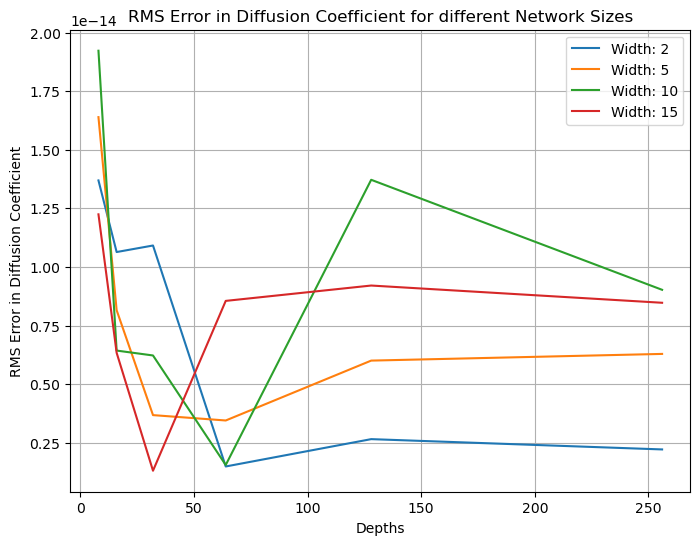

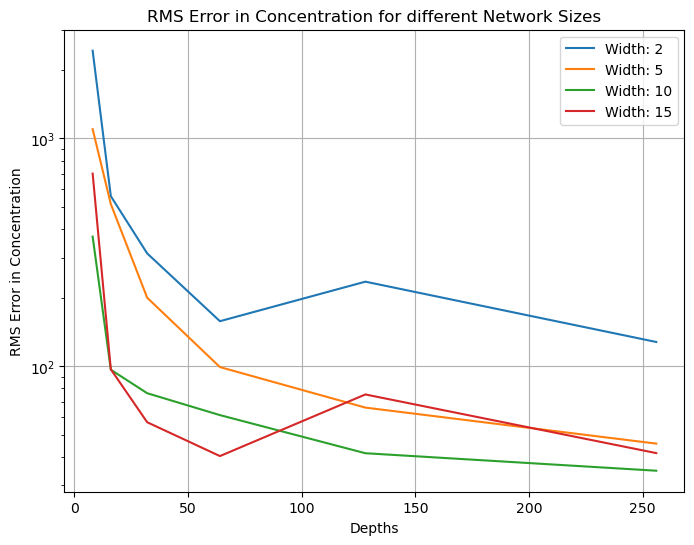

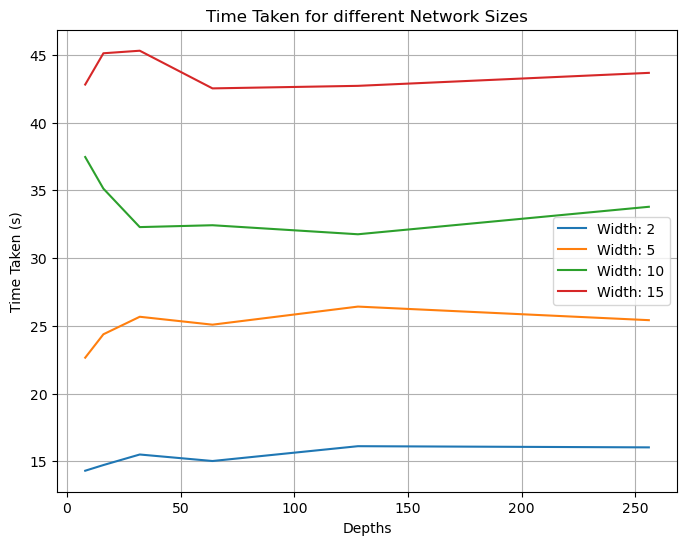

In [ ]:
# Plotting errors_D
fig = plt.figure(figsize=(8, 6))
for l in range(len(errors_D)):
    plt.plot(depths, errors_D[l], label=f'Width: {widths[l]}')
plt.xlabel('Depths')
plt.ylabel('RMS Error in Diffusion Coefficient')
plt.title('RMS Error in Diffusion Coefficient for different Network Sizes')
plt.legend()
plt.grid(True)
plt.show()

# Plotting errors_c
fig = plt.figure(figsize=(8, 6))
for l in range(len(errors_c)):
    plt.plot(depths, errors_c[l], label=f'Width: {widths[l]}')
plt.xlabel('Depths')
plt.ylabel('RMS Error in Concentration')
plt.title('RMS Error in Concentration for different Network Sizes')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

# Plotting times
fig = plt.figure(figsize=(8, 6))
for l in range(len(times)):
    plt.plot(depths, times[l], label=f'Width: {widths[l]}')
plt.xlabel('Depths')
plt.ylabel('Time Taken (s)')
plt.title('Time Taken for different Network Sizes')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# nn seed
torch.manual_seed(727)
device = 'cuda'
epochs_adam = 1000
lr_adam = 1e-4
epochs_lbfgs = 0

widths = [2, 5, 10, 15]
depths = [8, 16, 32, 64]

errors_D = np.zeros((len(widths), len(depths)))
errors_c = np.zeros((len(widths), len(depths)))
times = np.zeros((len(widths), len(depths)))

for i in range(len(widths)):
    for j in range(len(depths)):

        width = widths[i]
        depth = depths[j]

        start_time = time.time()
        
        pinn = Network(5, 64, width, depth, nn.SELU, nn.Tanh, 100, 100, device).to(device)
        losses, error_D, error_c = pinn.train(epochs_adam, lr_adam, epochs_lbfgs)
        
        errors_D[i, j] = error_D
        errors_c[i, j] = error_c

        times[i, j] = time.time() - start_time

In [43]:
# Plotting errors_D
fig = plt.figure(figsize=(8, 6))
for l in range(len(errors_D)):
    plt.plot(depths, errors_D[l], label=f'Width: {widths[l]}')
plt.xlabel('Depths')
plt.ylabel('RMS Error in Diffusion Coefficient')
plt.title('RMS Error in Diffusion Coefficient for different Network Sizes')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'errors_D' is not defined

<Figure size 800x600 with 0 Axes>

In [4]:
# nn seed
torch.manual_seed(727)
device = 'cuda'
epochs_adam = 3000
lr_adam = 1e-4
epochs_lbfgs = 0

activations = [nn.SELU, nn.ReLU, nn.Tanh, nn.Sigmoid]
losses = np.zeros((3300, len(activations)))
times = np.zeros((3300, len(activations)))
i = 0
for activation in activations:

        i+=1

        #start_time = time.time()

        if activation == nn.ReLU:
                epochs_adam = 3000
                epochs_lbfgs = 300
        else:
                epochs_adam = 3000
                epochs_lbfgs = 300
        
        pinn = Network(10, 64, 16, 5, activation, nn.Tanh, 100, 100, device).to(device)
        loss, error_D, error_c, timeeee = pinn.train(epochs_adam, lr_adam, epochs_lbfgs)

        losses[0:len(loss), i-1] = loss
        times[0:len(timeeee), i-1] = timeeee

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 2 subplots

# Plot for Loss vs Time
axs[0].set_title('Loss vs Time for different Activation Functions')
for i in range(len(activations)):
    cumulative_time = np.cumsum(times[:, i])
    axs[0].plot(cumulative_time, losses[:, i], label=f'{activations[i].__name__}')
    axs[1].plot(losses[:, i], label=f'{activations[i].__name__}')

axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)
axs[0].set_yscale('log')

# Plot for Loss vs Epoch
axs[1].set_title('Loss vs Epoch for different Activation Functions')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].set_yscale('log')
axs[1].grid(True)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

c:\Users\twcy2\anaconda3\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Pinn1
Pinn2ation: SELU, Width: 10  Depth: 64, D_Width: 5, D_Depth: 16,  Epoch: 1099  Loss: 3.2530503273010254


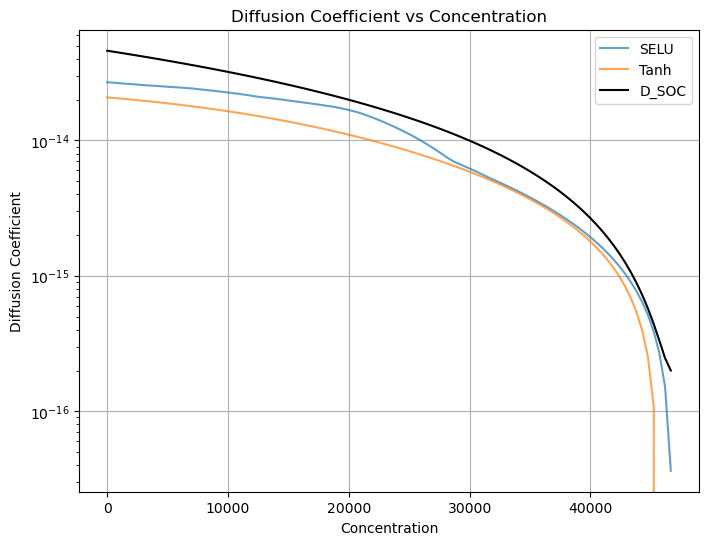

In [38]:
# nn seed
torch.manual_seed(727)
device = 'cuda'
epochs_adam = 1000
lr_adam = 1e-4
epochs_lbfgs = 100
c = torch.linspace(0, 1, 100).view(-1, 1).to(device)

print('Pinn1')
Pinn1 = Network(10, 64, 5, 16, nn.SELU, nn.SELU, 100, 100, device).to(device)
_, _, _, _ = Pinn1.train(epochs_adam, lr_adam, epochs_lbfgs)
D1 = Pinn1.forward_D(c).cpu().detach().numpy()

print('Pinn2')
Pinn2 = Network(10, 64, 5, 16, nn.SELU, nn.Tanh, 100, 100, device).to(device)
_, _, _, _ = Pinn2.train(epochs_adam, lr_adam, epochs_lbfgs)
D2 = Pinn2.forward_D(c).cpu().detach().numpy()


c = Pinn1.c_max*c.cpu().detach().numpy()
D_SOC = Pinn1.Diffusion_Coeff(c)

fig = plt.figure(figsize=(8, 6))
plt.plot(c, D1, label='SELU', alpha = 0.7)
plt.plot(c, D2, label='Tanh', alpha = 0.7)
plt.plot(c, D_SOC, label='D_SOC', color = 'black')
plt.xlabel('Concentration')
plt.ylabel('Diffusion Coefficient')
plt.title('Diffusion Coefficient vs Concentration')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

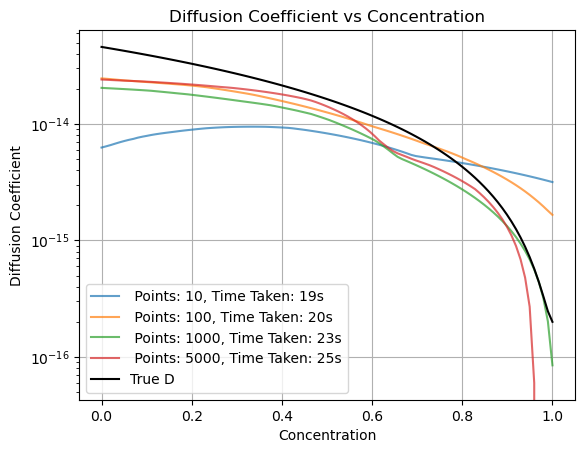

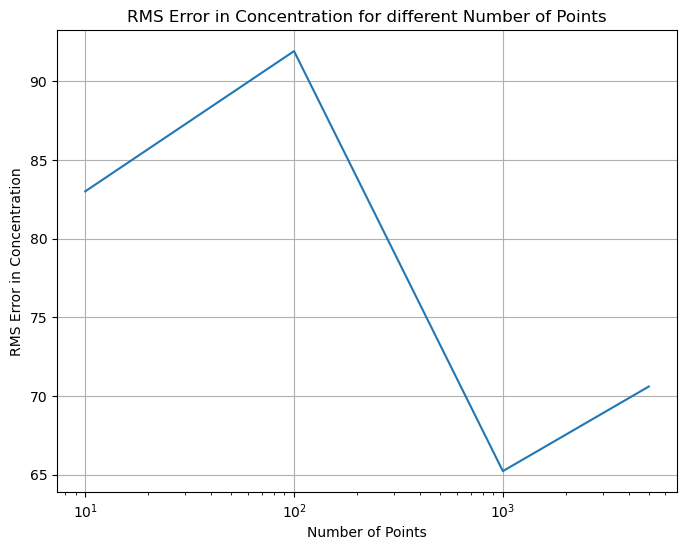

In [19]:
torch.manual_seed(727)
device = 'cuda'
epochs_adam = 500
lr_adam = 1e-4
epochs_lbfgs = 0

points = [10, 100, 1000, 5000]
errors_c = np.zeros(len(points))
times = np.zeros((len(points), epochs_adam + epochs_lbfgs))

c = torch.linspace(0, 1, 100).view(-1, 1).to(device)
Ds = np.zeros((100, len(points)))

for i in range(len(points)):
    pinn = Network(10, 64, 5, 16, nn.SELU, nn.SELU, points[i], 100, device).to(device)
    _, _, error_c, timeee = pinn.train(epochs_adam, lr_adam, epochs_lbfgs)
    errors_c[i] = error_c
    times[i, 0:len(timeee)] = timeee
    D = pinn.forward_D(c).cpu().detach().numpy()
    Ds[0:len(D), i:i+1] = D


D_SOC = pinn.Diffusion_Coeff(pinn.c_max*c.cpu().detach().numpy())

for i in range(len(points)):
    time_taken = sum(times[i])
    plt.plot(c.cpu().detach().numpy(), Ds[:, i], label=f' Points: {points[i]}, Time Taken: {round(time_taken)}s', alpha = 0.7)

plt.plot(c.cpu().detach().numpy(), D_SOC, label='True D', color='black')
plt.xlabel('Concentration')
plt.ylabel('Diffusion Coefficient')
plt.title('Diffusion Coefficient vs Concentration')
plt.legend()
plt.yscale('log')
plt.grid(True)  
plt.show()

fig = plt.figure(figsize=(8, 6))
plt.plot(points, errors_c)
plt.xlabel('Number of Points')
plt.ylabel('RMS Error in Concentration')
plt.title('RMS Error in Concentration for different Number of Points')
plt.grid(True)
plt.xscale('log')
plt.show()



In [40]:
torch.manual_seed(727)
device = 'cuda'
epochs_adam = 1000
lr_adam = 1e-4
epochs_lbfgs = 0

points = [10, 100, 1000, 5000]
errors_c = np.zeros((len(points), 10))
times = np.zeros((len(points), epochs_adam + epochs_lbfgs))

c = torch.linspace(0, 1, 100).view(-1, 1).to(device)
losses = np.zeros((epochs_adam+epochs_lbfgs, len(points)))

for i in range(len(points)):
    pinn = Network(10, 64, 5, 16, nn.SELU, nn.SELU, points[i], 100, device).to(device)   
    loss, _, error_c, timeee = pinn.train(epochs_adam, lr_adam, epochs_lbfgs)
    losses[0:len(loss), i] = loss



fig = plt.figure()


for i in range(len(points)):
    plt.plot(losses[:, i], label=f'Points: {points[i]}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs for different Number of Points')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.show()



cuda:0
cuda:0
cuda:0
cuda:0
cuda:0tion: SELU, Width: 10  Depth: 64, D_Width: 5, D_Depth: 16,  Epoch: 0  Loss: 44272.74609375
cuda:0
cuda:0
cuda:0
cuda:0tion: SELU, Width: 10  Depth: 64, D_Width: 5, D_Depth: 16,  Epoch: 1  Loss: 33070.3046875
cuda:0
cuda:0
cuda:0
cuda:0tion: SELU, Width: 10  Depth: 64, D_Width: 5, D_Depth: 16,  Epoch: 2  Loss: 24820.986328125
cuda:0
cuda:0
cuda:0
cuda:0tion: SELU, Width: 10  Depth: 64, D_Width: 5, D_Depth: 16,  Epoch: 3  Loss: 19563.904296875
cuda:0
cuda:0
cuda:0
cuda:0tion: SELU, Width: 10  Depth: 64, D_Width: 5, D_Depth: 16,  Epoch: 4  Loss: 16996.591796875
cuda:0
cuda:0
cuda:0
cuda:0tion: SELU, Width: 10  Depth: 64, D_Width: 5, D_Depth: 16,  Epoch: 5  Loss: 16597.779296875
cuda:0
cuda:0
cuda:0
cuda:0tion: SELU, Width: 10  Depth: 64, D_Width: 5, D_Depth: 16,  Epoch: 6  Loss: 17262.076171875
cuda:0
cuda:0
cuda:0
cuda:0tion: SELU, Width: 10  Depth: 64, D_Width: 5, D_Depth: 16,  Epoch: 7  Loss: 18175.994140625
cuda:0
cuda:0
cuda:0
cuda:0tion: SELU, Width

KeyboardInterrupt: 

In [11]:
print(losses)

[313767.5625, 261707.5625, 214025.21875, 172104.640625, 135983.171875, 104336.6484375, 77182.203125, 54619.71875, 36816.17578125, 23370.279296875, 13916.638671875, 8314.625, 6274.77685546875, 7254.8515625, 10407.0400390625, 14654.921875, 18920.236328125, 22308.728515625, 24301.478515625, 24742.533203125, 23773.37109375, 21720.75, 18993.03125, 16003.02734375, 13098.6611328125, 10560.8818359375, 8553.0078125, 7135.77978515625, 6308.36962890625, 5977.39892578125, 6032.853515625, 6348.3173828125, 6798.29248046875, 7273.6572265625, 7687.39453125, 7976.4814453125, 8106.20751953125, 8064.7880859375, 7862.33056640625, 7533.01318359375, 7103.69482421875, 6630.25, 6157.939453125, 5709.06982421875, 5330.4814453125, 5036.3759765625, 4834.16748046875, 4721.40576171875, 4686.76953125, 4713.34814453125, 4765.27734375, 4822.5517578125, 4865.0283203125, 4875.1259765625, 4857.33837890625, 4775.65234375, 4675.2998046875, 4545.9609375, 4412.84033203125, 4285.19189453125, 4174.96142578125, 4084.54638671875

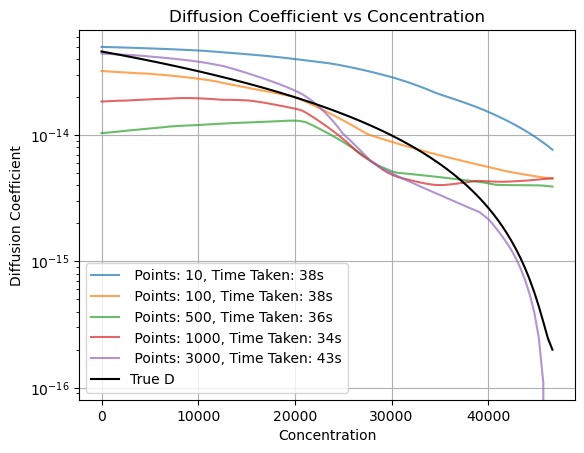

In [14]:
torch.manual_seed(0)
device = 'cuda'
epochs_adam = 1000
lr_adam = 1e-4
epochs_lbfgs = 0

points = [10, 100, 500, 1000, 3000]
errors_c = np.zeros(len(points))
times = np.zeros((len(points), epochs_adam + epochs_lbfgs))

c = torch.linspace(0, 1, 100).view(-1, 1).to(device)
Ds = np.zeros((100, len(points)))

for i in range(len(points)):
    pinn = Network(10, 64, 5, 16, nn.SELU, nn.SELU, 100, points[i], device).to(device)
    _, _, error_c, timeee = pinn.train(epochs_adam, lr_adam, epochs_lbfgs)
    errors_c[i] = error_c
    times[i, 0:len(timeee)] = timeee
    D = pinn.forward_D(c).cpu().detach().numpy()
    Ds[0:len(D), i:i+1] = D


D_SOC = pinn.Diffusion_Coeff(pinn.c_max*c.cpu().detach().numpy())

for i in range(len(points)):
    time_taken = sum(times[i])
    plt.plot(pinn.c_max*c.cpu().detach().numpy(), Ds[:, i], label=f' Points: {points[i]}, Time Taken: {round(time_taken)}s', alpha = 0.7)

plt.plot(pinn.c_max*c.cpu().detach().numpy(), D_SOC, label='True D', color='black')
plt.xlabel('Concentration')
plt.ylabel('Diffusion Coefficient')
plt.title('Diffusion Coefficient vs Concentration')
plt.legend()
plt.yscale('log')
plt.grid(True)  
plt.show()


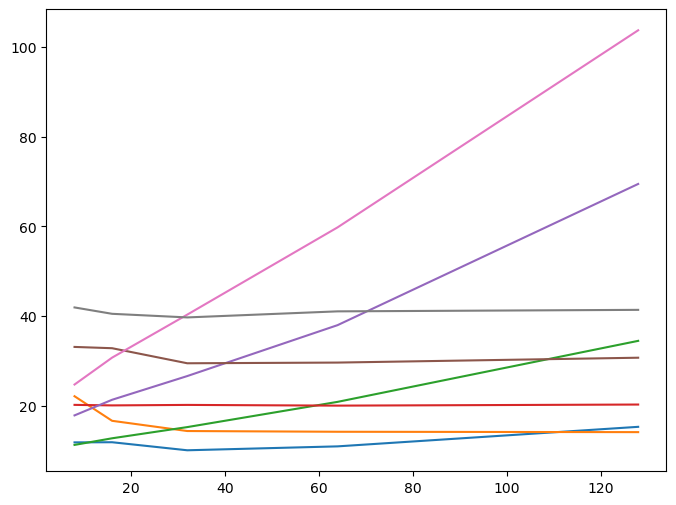

In [50]:
devices = ['cpu', 'cuda']
depths = [8, 16, 32, 64, 128]
widths = [2, 5, 10, 15]
epochs_adam = 1000
epochs_lbfgs = 0

times_cpu = np.zeros((len(widths), len(depths)))
times_cuda = np.zeros((len(widths), len(depths)))

for i in range(len(widths)):
    for j in range(len(depths)):

        width = widths[i]
        depth = depths[j]

        start_time = time.time()
        device = 'cpu'
        pinn = Network(width, depth, 5, 16, nn.SELU, nn.Tanh, 100, 100, 'cpu').to('cpu')
        _, _, _, time_cpu = pinn.train(epochs_adam, lr_adam, epochs_lbfgs)
        times_cpu[i, j] = np.sum(time_cpu)

        device = 'cuda'
        pinn = Network(width, depth, 5, 16, nn.SELU, nn.Tanh, 100, 100, 'cuda').to('cuda')
        _, _, _, time_cuda = pinn.train(epochs_adam, lr_adam, epochs_lbfgs)
        times_cuda[i, j] = np.sum(time_cuda)

# Plotting times
fig = plt.figure(figsize=(8, 6))
for l in range(len(widths)):
    plt.plot(depths, times_cpu[l], label=f'Width: {widths[l]}, Device: CPU')
    plt.plot(depths, times_cuda[l], label=f'Width: {widths[l]}, Device: CUDA')
                      

In [32]:
# Plotting times
fig = plt.figure(figsize=(8, 6))

markers = ['o', 's', '^', 'v']  # Define different markers for each line
for l in range(len(widths)):
    plt.plot(depths, times_cpu[l], marker=markers[l], label=f'Width: {widths[l]}, Device: CPU', color='red')
    plt.plot(depths, times_cuda[l], marker=markers[l], label=f'Width: {widths[l]}, Device: CUDA', color='blue')

plt.xlabel('Depths')
plt.ylabel('Time Taken (s)')
plt.title('Time Taken for different Network Sizes')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'widths' is not defined

<Figure size 800x600 with 0 Axes>

c:\Users\twcy2\anaconda3\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


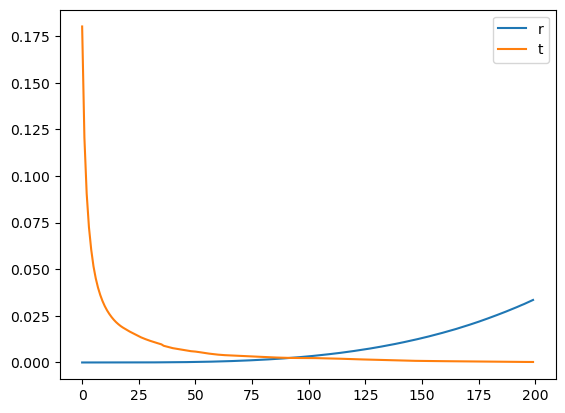

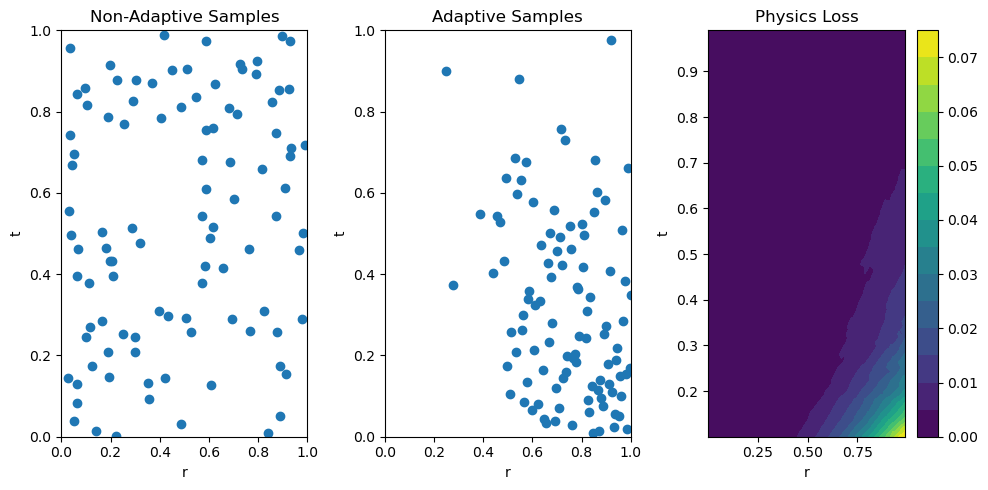

In [4]:
# nn seed

torch.manual_seed(727)
device = 'cuda'
epochs_adam = 300
lr_adam = 1e-4
epochs_lbfgs = 100

pinn = Network(10, 64, 5, 16, nn.SELU, nn.SELU, 100, 100, device).to(device)

#losses, error_D, error_c, times = pinn.train(epochs_adam, lr_adam, epochs_lbfgs)

r = torch.linspace(0.001, 0.99, 100).to(device).requires_grad_(True)
t = torch.linspace(0.1, 0.99, 100).to(device).requires_grad_(True)
r_grid, t_grid = torch.meshgrid(r, t)
nonadaptive = pinn.sample(100)
adaptive = pinn.adaptive_sample(100)
loss = pinn.phys_loss(r_grid.flatten().unsqueeze(1), t_grid.flatten().unsqueeze(1)).view(100, 100).cpu().detach().numpy()

fig = plt.subplots(1, 3, figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.scatter(nonadaptive[0].cpu().detach().numpy(), nonadaptive[1].cpu().detach().numpy())
plt.title('Non-Adaptive Samples')
plt.xlabel('r')
plt.ylabel('t')
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.subplot(1, 3, 2)
plt.scatter(adaptive[0].cpu().detach().numpy(), adaptive[1].cpu().detach().numpy())
plt.title('Adaptive Samples')
plt.xlabel('r')
plt.ylabel('t')
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.subplot(1, 3, 3)
plt.contourf(r_grid.cpu().detach().numpy(), t_grid.cpu().detach().numpy(), loss, levels  = 15)
plt.title('Physics Loss')
plt.xlabel('r')
plt.ylabel('t')
plt.colorbar()

plt.tight_layout()

pinn.plot_comparison()

In [19]:
class Network2(nn.Module):

  def __init__(self, width, depth, width_D, depth_D, activation, D_activation, N, N_data, device):
    super().__init__()
    # optimisers    

    # constants and stuff
    device = device
    self.N = N
    self.N_data = N_data
    self.r_data, self.t_data = self.sample(self.N_data)
    self.c_numerical = torch.tensor(self.NumericalSoln(self.r_data.cpu().detach().numpy(), self.t_data.cpu().detach().numpy())).to(device)
    self.r0_boundary, self.rs_boundary, self.t_boundaries, self.t0_boundary, self.r_boundary = self.init_boundaries(N)
    self.j = -5.35e-5
    self.Rs = torch.tensor(2e-6)
    self.c_max = 4.665e4
    self.c0 = torch.tensor(2e4).view(-1, 1).to(device)
    self.D_ref = 2e-16
    self.C_theory = 277.84
    self.C_practical = 160

    # storing D and loss values
    self.Ds = []
    self.loss_list = []
    self.r0_loss_list = []
    self.rs_loss_list = []
    self.phys_loss_list = []
    self.comp_loss_list = []

    # nn constants
    #activation = nn.SELU
    #D_activation = nn.Tanh
    self.D_hidden = depth_D # number of neurons in hidden layers for D
    self.D_layers = width_D # number of hidden layers for D
    self.input = 2 # input is r and t
    self.output = 1 # output is c
    self.layers = width # number of hidden layers
    self.hidden = depth # number of neurons in hidden layers
    self.activation = activation

    # c network
    self.fci = nn.Sequential(*[nn.Linear(self.input, self.hidden), activation()])
    init.kaiming_normal_(self.fci[0].weight, nonlinearity='tanh')
    self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(self.hidden, self.hidden), activation()]) for i in range(self.layers-1)])
    for layer in self.fch.children():
      if isinstance(layer, nn.Linear):
          init.kaiming_normal_(layer.weight, nonlinearity='tanh')
    self.fco = nn.Linear(self.hidden, self.output)

    # D network
    self.fciD = nn.Sequential(*[nn.Linear(1, self.D_hidden), D_activation()])
    init.kaiming_normal_(self.fciD[0].weight)
    self.fchD = nn.Sequential(*[nn.Sequential(*[nn.Linear(self.D_hidden, self.D_hidden), D_activation()]) for i in range(self.D_layers-1)])
    for layer in self.fchD.children():
      if isinstance(layer, nn.Linear):
          init.kaiming_normal_(layer.weight)
    self.fcoD = nn.Linear(self.D_hidden, 1)

  # c forward propagation
  def forward_c(self, x, t):
    x = torch.cat((x, t), dim = 1)
    x = self.fci(x)
    x = self.fch(x)
    x = self.fco(x)
    x = self.c0/self.c_max + x
    return x
  
  # D forward propagation
  def forward_D(self, x):
    x = self.fciD(x)
    x = self.fchD(x)
    x = self.fcoD(x)
    x = x*1e-13
    return x
  
  # numerical solution of spherical diffusion equation
  def NumericalSoln(self, r_data, t_data):

    numerical_sol = pd.read_csv("MATLAB Solver\data.csv")
    
    sol = []
    for i in range(len(r_data)):
      r = np.round(9999 * r_data[i]).astype(int)[0]
      t = np.round(399 * t_data[i]).astype(int)[0]  
      
      c = numerical_sol.iloc[r, t]
      sol.append(c)
    return sol
  
  
  def init_boundaries(self, N):

    # x and t boundary points for training x boundaries, x = 0,1, varying t values
    r0_boundary = torch.tensor(0.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    rs_boundary = torch.tensor(1.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    t_boundaries = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)

    # 0 time boundary for training
    t0_boundary = torch.tensor(0.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    r_boundary = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)

    return r0_boundary, rs_boundary, t_boundaries, t0_boundary, r_boundary

  def sample(self, N):
        
    # sample points for training
    r = torch.rand(N).view(-1, 1).requires_grad_(True).to(device).view(-1, 1)
    t = torch.rand(N).view(-1, 1).requires_grad_(True).to(device).view(-1, 1)

    return r, t

# adaptive sampling, unused due to VRAM limitations
  def adaptive_sample(self, N):
    
    r = torch.linspace(0.01, 0.99999, 2*N).requires_grad_(True).to(device)
    t = torch.linspace(0.01, 0.99999, 2*N).requires_grad_(True).to(device)
    r_grid, t_grid = torch.meshgrid(r, t)
    phys_loss = self.phys_loss(r_grid.flatten().unsqueeze(1), t_grid.flatten().unsqueeze(1)).view(2*N, 2*N)

    phys_loss_r = torch.mean(phys_loss, dim=1)
    phys_loss_t = torch.mean(phys_loss, dim=0)
    
    plt.plot(phys_loss_r.cpu().detach().numpy(), label='r')
    plt.plot(phys_loss_t.cpu().detach().numpy(), label='t')
    plt.legend()

    r_ids = torch.multinomial(phys_loss_r, N, replacement=False)
    t_ids = torch.multinomial(phys_loss_t, N, replacement=False)
    r = r[r_ids]
    t = t[t_ids]

    return r, t

  def Diffusion_Coeff(self, c):

    SOC = (self.c_max - c)/self.c_max * self.C_theory/self.C_practical
    D = self.D_ref * (1 + 100*SOC**(3/2))

    return D
  
  def deriv_t(self, c, t):
    return torch.autograd.grad(c, t, grad_outputs=torch.ones_like(c).to(device), create_graph=True)[0]
  
  def deriv_r(self, c, r):
    return torch.autograd.grad(c, r, grad_outputs=torch.ones_like(c).to(device), create_graph=True)[0]
  
  def phys_loss(self, r, t):

    Rs = self.Rs
    c = self.forward_c(r, t)
    c_r = self.deriv_r(c, r)
    c_rr = self.deriv_r(c_r, r)
    c_t = self.deriv_t(c, t)
    D = self.forward_D(c)
    D_r = self.deriv_r(D, r)
    term = r**2*D*c_r/(Rs**2)
    deriv = self.deriv_r(term, r)

    #loss = (r**2*c_t - (2*r*c_r - D*r**2*c_rr - D_r*r**2*c_r)/(Rs**2))**2
    loss = (r**2*c_t - deriv)**2
    return loss

  def losses(self):
    
    r_phys, t_phys = self.sample(self.N)
    j, Rs, c_max, c0 = self.j, self.Rs, self.c_max, self.c0 

    # loss for r = 0 boundary
    c = self.forward_c(self.r0_boundary, self.t_boundaries)
    c_r = self.deriv_r(c, self.r0_boundary)
    r0_loss = c_r**2
    self.r0_loss_list.append(torch.mean(r0_loss).item())
    
    # loss for x = rs boundary
    c = self.forward_c(self.rs_boundary, self.t_boundaries)
    c_r = self.deriv_r(c, self.rs_boundary)
    D = self.forward_D(c)
    rs_loss = (D*c_r + j*Rs/c_max)**2
    self.rs_loss_list.append(torch.mean(rs_loss).item())

    # physics loss
    phys_loss = self.phys_loss(r_phys, t_phys)
    self.phys_loss_list.append(torch.mean(phys_loss).item())
    
    # comparative loss
    c = self.c_max*self.forward_c(self.r_data, self.t_data)
    comp_loss = 1/self.c_max*(torch.sub(c, self.c_numerical.unsqueeze(1)))**2
    self.comp_loss_list.append(torch.mean(comp_loss).item())

    loss = torch.mean(r0_loss) + 1e28*torch.mean(rs_loss) + 100*torch.mean(phys_loss) + 100*torch.mean(comp_loss)

    return loss
  
  def closure(self):
    self.optimizer_lbfgs.zero_grad()
    loss = self.losses()
    loss.backward()
    return loss
  
  def train(self, epochs_adam, lr_adam, epochs_lbfgs):

    # Adam
    optimizer_adam = torch.optim.Adam(self.parameters(), lr = lr_adam)
    times = []

    for epoch in range(epochs_adam):
      
      start_time = time.perf_counter()
      self.epoch = epoch
      
      optimizer_adam.zero_grad()
      loss = self.losses()
      self.loss_list.append(loss.item())
      loss.backward()
      optimizer_adam.step()
      #print(f'Epoch: {epoch}  Loss: {loss.item()}', end='\r')
      print(f'Activation: {self.activation.__name__}, Width: {self.layers}  Depth: {self.hidden}, D_Width: {self.D_layers}, D_Depth: {self.D_hidden},  Epoch: {self.epoch}  Loss: {loss.item()}', end='\r')
      end_time = time.perf_counter()
      times.append(end_time - start_time)


    # LBFGS
    self.optimizer_lbfgs = torch.optim.LBFGS(self.parameters(), 
                                        max_iter=400, 
                                        history_size=400, 
                                        tolerance_grad=1.0 * np.finfo(float).eps, 
                                        tolerance_change=1.0 * np.finfo(float).eps, 
                                        line_search_fn='strong_wolfe')
    for epoch in range(epochs_lbfgs):

      start_time = time.perf_counter()
      loss = self.optimizer_lbfgs.step(self.closure)
      self.loss_list.append(loss.item())

      self.epoch = epochs_adam + epoch

      if np.isnan(loss.item()):
        break
      end_time = time.perf_counter()
      times.append(end_time - start_time)
      print(f'Activation: {self.activation.__name__}, Width: {self.layers}  Depth: {self.hidden}, D_Width: {self.D_layers}, D_Depth: {self.D_hidden},  Epoch: {self.epoch}  Loss: {loss.item()}', end='\r')
      

    error_D = self.error_D()
    error_c = self.error()

    return self.loss_list, error_D, error_c, times

  def plot(self):

      X = torch.linspace(0, 1, 100).to(device)
      T = torch.linspace(0, 1, 100).to(device)
      X_grid, T_grid = torch.meshgrid(X, T)
      
      C = self.c_max*self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
      C = C.view(100, 100)
      C = C.cpu().detach().numpy()
      
      X, T = np.meshgrid(self.Rs*X.cpu().detach().numpy(), 400*T.cpu().detach().numpy())

      fig = go.Figure(data=[go.Surface(z=C, x=X, y=T)])
      fig.update_layout(template = 'plotly_dark', 
                        title='Concentration vs Time and Radius', 
                        scene = dict(xaxis = dict(title = 'Radius'),
                        yaxis = dict(title = 'Time (s)'),
                        zaxis = dict(title = 'Concentration')),                        
                        autosize=False, width=800, height=600, margin=dict(l=50, r=50, t=50, b=50))
      fig.show()

  def error_D(self):

    c = torch.linspace(0, 1, 100).view(-1, 1).to(device)
    D = self.forward_D(c).cpu().detach().numpy()
    c = self.c_max*c.cpu().detach().numpy()
    D_SOC = self.Diffusion_Coeff(c)

    error_D = np.mean(np.sqrt((D - D_SOC)**2))

    return error_D


  def plot_loss(self):
    fig = px.scatter(
            x=range(len(self.loss_list)),
            y=self.loss_list,
            log_y=True,
            log_x=True,
            color=np.log(self.loss_list),
            color_continuous_scale="Agsunset",
            labels={"x": "Epochs", "y": "Loss"},
            template='plotly_dark'
        )
    fig.show()

    plt.plot(self.r0_loss_list, label='r0_loss')
    plt.plot(self.rs_loss_list, label='rs_loss')
    plt.plot(self.phys_loss_list, label='phys_loss')
    #plt.plot(self.comp_loss_list, label='comp_loss')
    plt.legend()
    plt.show()

  def plot_comparison(self):

    numerical = pd.read_csv("MATLAB Solver\data.csv")
    X = torch.linspace(0, 1, 100).to(device).requires_grad_(True)
    T = torch.linspace(0, 1, 100).to(device).requires_grad_(True)
    X_grid, T_grid = torch.meshgrid(X, T)

    C = self.c_max*self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
    C = C.view(100, 100)
    C = C.cpu().detach().numpy()

    X = np.round(10000*X.cpu().detach().numpy())
    T = np.round(400*T.cpu().detach().numpy())

    fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{}, {}]], subplot_titles=('Comparison at t=0', 'Comparison at t=end', 'Comparison at r=0', 'Comparison at r=end'))

    fig.add_trace(go.Scatter(y=numerical.iloc[:, 0], mode='lines', name='Numerical', showlegend=True, line=dict(color="#2EBFA5")), row=1, col=1)
    fig.add_trace(go.Scatter(x=X, y=C[:, 0], mode='lines', name='NN', showlegend=True, line=dict(color="#3590F3")), row=1, col=1)

    fig.add_trace(go.Scatter(y=numerical.iloc[:, -1], mode='lines', name='Numerical', showlegend=False, line=dict(color="#2EBFA5")), row=1, col=2)
    fig.add_trace(go.Scatter(x=X, y=C[:, -1], mode='lines', name='NN', showlegend=False, line=dict(color="#3590F3")), row=1, col=2)

    fig.add_trace(go.Scatter(y=numerical.iloc[0, :], mode='lines', name='Numerical', showlegend=False, line=dict(color="#2EBFA5")), row=2, col=1)
    fig.add_trace(go.Scatter(x=T, y=C[0, :], mode='lines', name='NN', showlegend=False, line=dict(color="#3590F3")), row=2, col=1)

    fig.add_trace(go.Scatter(y=numerical.iloc[-1, :], mode='lines', name='Numerical', showlegend=False, line=dict(color="#2EBFA5")), row=2, col=2)
    fig.add_trace(go.Scatter(x=T, y=C[-1, :], mode='lines', name='NN', showlegend=False, line=dict(color="#3590F3")), row=2, col=2)

    fig.update_layout(autosize=False, width=800, height=600, margin=dict(l=50, r=50, t=50, b=50), showlegend=True, template = 'plotly_dark')

    fig.show()
      
  def error(self):
    
    X = torch.linspace(0, 0.99, 101).to(device).requires_grad_(True)
    T = torch.linspace(0, 0.99, 101).to(device).requires_grad_(True)
    X_grid, T_grid = torch.meshgrid(X, T)
    C = self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
    C = self.c_max*C.view(101, 101)
    X_int = np.round(10000*X.cpu().detach().numpy()).astype(int)
    T_int = np.round(400*T.cpu().detach().numpy()).astype(int)

    numerical = pd.read_csv("MATLAB Solver\data.csv").to_numpy()
    numerical = numerical[np.ix_(X_int, T_int)]

    abs_error = np.mean(np.sqrt((numerical - C.cpu().detach().numpy())**2))
    
    return abs_error
    


In [21]:
class Network3(nn.Module):

  def __init__(self, width, depth, width_D, depth_D, activation, D_activation, N, N_data, device):
    super().__init__()
    # optimisers    

    # constants and stuff
    device = device
    self.N = N
    self.N_data = N_data
    self.r_data, self.t_data = self.sample(self.N_data)
    self.c_numerical = torch.tensor(self.NumericalSoln(self.r_data.cpu().detach().numpy(), self.t_data.cpu().detach().numpy())).to(device)
    self.r0_boundary, self.rs_boundary, self.t_boundaries, self.t0_boundary, self.r_boundary = self.init_boundaries(N)
    self.j = -5.35e-5
    self.Rs = torch.tensor(2e-6)
    self.c_max = 4.665e4
    self.c0 = torch.tensor(2e4).view(-1, 1).to(device)
    self.D_ref = 2e-16
    self.C_theory = 277.84
    self.C_practical = 160

    # storing D and loss values
    self.Ds = []
    self.loss_list = []
    self.r0_loss_list = []
    self.rs_loss_list = []
    self.phys_loss_list = []
    self.comp_loss_list = []

    # nn constants
    #activation = nn.SELU
    #D_activation = nn.Tanh
    self.D_hidden = depth_D # number of neurons in hidden layers for D
    self.D_layers = width_D # number of hidden layers for D
    self.input = 2 # input is r and t
    self.output = 1 # output is c
    self.layers = width # number of hidden layers
    self.hidden = depth # number of neurons in hidden layers
    self.activation = activation

    # c network
    self.fci = nn.Sequential(*[nn.Linear(self.input, self.hidden), activation()])
    init.kaiming_normal_(self.fci[0].weight, nonlinearity='tanh')
    self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(self.hidden, self.hidden), activation()]) for i in range(self.layers-1)])
    for layer in self.fch.children():
      if isinstance(layer, nn.Linear):
          init.kaiming_normal_(layer.weight, nonlinearity='tanh')
    self.fco = nn.Linear(self.hidden, self.output)

    # D network
    self.fciD = nn.Sequential(*[nn.Linear(1, self.D_hidden), D_activation()])
    init.kaiming_normal_(self.fciD[0].weight)
    self.fchD = nn.Sequential(*[nn.Sequential(*[nn.Linear(self.D_hidden, self.D_hidden), D_activation()]) for i in range(self.D_layers-1)])
    for layer in self.fchD.children():
      if isinstance(layer, nn.Linear):
          init.kaiming_normal_(layer.weight)
    self.fcoD = nn.Linear(self.D_hidden, 1)

  # c forward propagation
  def forward_c(self, x, t):
    x = torch.cat((x, t), dim = 1)
    x = self.fci(x)
    x = self.fch(x)
    x = self.fco(x)
    x = self.c0/self.c_max + t*x
    return x
  
  # D forward propagation
  def forward_D(self, x):
    x = self.fciD(x)
    x = self.fchD(x)
    x = self.fcoD(x)
    x = x*1e-13
    return x
  
  # numerical solution of spherical diffusion equation
  def NumericalSoln(self, r_data, t_data):

    numerical_sol = pd.read_csv("MATLAB Solver\data.csv")
    
    sol = []
    for i in range(len(r_data)):
      r = np.round(9999 * r_data[i]).astype(int)[0]
      t = np.round(399 * t_data[i]).astype(int)[0]  
      
      c = numerical_sol.iloc[r, t]
      sol.append(c)
    return sol
  
  
  def init_boundaries(self, N):

    # x and t boundary points for training x boundaries, x = 0,1, varying t values
    r0_boundary = torch.tensor(0.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    rs_boundary = torch.tensor(1.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    t_boundaries = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)

    # 0 time boundary for training
    t0_boundary = torch.tensor(0.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    r_boundary = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)

    return r0_boundary, rs_boundary, t_boundaries, t0_boundary, r_boundary

  def sample(self, N):
        
    # sample points for training
    r = torch.rand(N).view(-1, 1).requires_grad_(True).to(device).view(-1, 1)
    t = torch.rand(N).view(-1, 1).requires_grad_(True).to(device).view(-1, 1)

    return r, t

# adaptive sampling, unused due to VRAM limitations
  def adaptive_sample(self, N):
    
    r = torch.linspace(0.01, 0.99999, 2*N).requires_grad_(True).to(device)
    t = torch.linspace(0.01, 0.99999, 2*N).requires_grad_(True).to(device)
    r_grid, t_grid = torch.meshgrid(r, t)
    phys_loss = self.phys_loss(r_grid.flatten().unsqueeze(1), t_grid.flatten().unsqueeze(1)).view(2*N, 2*N)

    phys_loss_r = torch.mean(phys_loss, dim=1)
    phys_loss_t = torch.mean(phys_loss, dim=0)
    
    plt.plot(phys_loss_r.cpu().detach().numpy(), label='r')
    plt.plot(phys_loss_t.cpu().detach().numpy(), label='t')
    plt.legend()

    r_ids = torch.multinomial(phys_loss_r, N, replacement=False)
    t_ids = torch.multinomial(phys_loss_t, N, replacement=False)
    r = r[r_ids]
    t = t[t_ids]

    return r, t

  def Diffusion_Coeff(self, c):

    SOC = (self.c_max - c)/self.c_max * self.C_theory/self.C_practical
    D = self.D_ref * (1 + 100*SOC**(3/2))

    return D
  
  def deriv_t(self, c, t):
    return torch.autograd.grad(c, t, grad_outputs=torch.ones_like(c).to(device), create_graph=True)[0]
  
  def deriv_r(self, c, r):
    return torch.autograd.grad(c, r, grad_outputs=torch.ones_like(c).to(device), create_graph=True)[0]
  
  def phys_loss(self, r, t):

    Rs = self.Rs
    c = self.forward_c(r, t)
    c_r = self.deriv_r(c, r)
    c_rr = self.deriv_r(c_r, r)
    c_t = self.deriv_t(c, t)
    D = self.forward_D(c)
    D_r = self.deriv_r(D, r)
    term = r**2*D*c_r/(Rs**2)
    deriv = self.deriv_r(term, r)

    #loss = (r**2*c_t - (2*r*c_r - D*r**2*c_rr - D_r*r**2*c_r)/(Rs**2))**2
    loss = (r**2*c_t - deriv)**2
    return loss

  def losses(self):
    
    r_phys, t_phys = self.sample(self.N)
    j, Rs, c_max, c0 = self.j, self.Rs, self.c_max, self.c0 

    # loss for r = 0 boundary
    c = self.forward_c(self.r0_boundary, self.t_boundaries)
    c_r = self.deriv_r(c, self.r0_boundary)
    r0_loss = c_r**2
    self.r0_loss_list.append(torch.mean(r0_loss).item())
    
    # loss for x = rs boundary
    c = self.forward_c(self.rs_boundary, self.t_boundaries)
    c_r = self.deriv_r(c, self.rs_boundary)
    D = self.forward_D(c)
    rs_loss = (D*c_r + j*Rs/c_max)**2
    self.rs_loss_list.append(torch.mean(rs_loss).item())

    # physics loss
    phys_loss = self.phys_loss(r_phys, t_phys)
    self.phys_loss_list.append(torch.mean(phys_loss).item())
    
    # comparative loss
    c = self.c_max*self.forward_c(self.r_data, self.t_data)
    comp_loss = 1/self.c_max*(torch.sub(c, self.c_numerical.unsqueeze(1)))**2
    self.comp_loss_list.append(torch.mean(comp_loss).item())

    loss = torch.mean(r0_loss) + 1e28*torch.mean(rs_loss) + 100*torch.mean(phys_loss) + 100*torch.mean(comp_loss)

    return loss
  
  def closure(self):
    self.optimizer_lbfgs.zero_grad()
    loss = self.losses()
    loss.backward()
    return loss
  
  def train(self, epochs_adam, lr_adam, epochs_lbfgs):

    # Adam
    optimizer_adam = torch.optim.Adam(self.parameters(), lr = lr_adam)
    times = []

    for epoch in range(epochs_adam):
      
      start_time = time.perf_counter()
      self.epoch = epoch
      
      optimizer_adam.zero_grad()
      loss = self.losses()
      self.loss_list.append(loss.item())
      loss.backward()
      optimizer_adam.step()
      #print(f'Epoch: {epoch}  Loss: {loss.item()}', end='\r')
      print(f'Activation: {self.activation.__name__}, Width: {self.layers}  Depth: {self.hidden}, D_Width: {self.D_layers}, D_Depth: {self.D_hidden},  Epoch: {self.epoch}  Loss: {loss.item()}', end='\r')
      end_time = time.perf_counter()
      times.append(end_time - start_time)


    # LBFGS
    self.optimizer_lbfgs = torch.optim.LBFGS(self.parameters(), 
                                        max_iter=400, 
                                        history_size=400, 
                                        tolerance_grad=1.0 * np.finfo(float).eps, 
                                        tolerance_change=1.0 * np.finfo(float).eps, 
                                        line_search_fn='strong_wolfe')
    for epoch in range(epochs_lbfgs):

      start_time = time.perf_counter()
      loss = self.optimizer_lbfgs.step(self.closure)
      self.loss_list.append(loss.item())

      self.epoch = epochs_adam + epoch

      if np.isnan(loss.item()):
        break
      end_time = time.perf_counter()
      times.append(end_time - start_time)
      print(f'Activation: {self.activation.__name__}, Width: {self.layers}  Depth: {self.hidden}, D_Width: {self.D_layers}, D_Depth: {self.D_hidden},  Epoch: {self.epoch}  Loss: {loss.item()}', end='\r')
      

    error_D = self.error_D()
    error_c = self.error()

    return self.loss_list, error_D, error_c, times

  def plot(self):

      X = torch.linspace(0, 1, 100).to(device)
      T = torch.linspace(0, 1, 100).to(device)
      X_grid, T_grid = torch.meshgrid(X, T)
      
      C = self.c_max*self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
      C = C.view(100, 100)
      C = C.cpu().detach().numpy()
      
      X, T = np.meshgrid(self.Rs*X.cpu().detach().numpy(), 400*T.cpu().detach().numpy())

      fig = go.Figure(data=[go.Surface(z=C, x=X, y=T)])
      fig.update_layout(template = 'plotly_dark', 
                        title='Concentration vs Time and Radius', 
                        scene = dict(xaxis = dict(title = 'Radius'),
                        yaxis = dict(title = 'Time (s)'),
                        zaxis = dict(title = 'Concentration')),                        
                        autosize=False, width=800, height=600, margin=dict(l=50, r=50, t=50, b=50))
      fig.show()

  def error_D(self):

    c = torch.linspace(0, 1, 100).view(-1, 1).to(device)
    D = self.forward_D(c).cpu().detach().numpy()
    c = self.c_max*c.cpu().detach().numpy()
    D_SOC = self.Diffusion_Coeff(c)

    error_D = np.mean(np.sqrt((D - D_SOC)**2))

    return error_D


  def plot_loss(self):
    fig = px.scatter(
            x=range(len(self.loss_list)),
            y=self.loss_list,
            log_y=True,
            log_x=True,
            color=np.log(self.loss_list),
            color_continuous_scale="Agsunset",
            labels={"x": "Epochs", "y": "Loss"},
            template='plotly_dark'
        )
    fig.show()

    plt.plot(self.r0_loss_list, label='r0_loss')
    plt.plot(self.rs_loss_list, label='rs_loss')
    plt.plot(self.phys_loss_list, label='phys_loss')
    #plt.plot(self.comp_loss_list, label='comp_loss')
    plt.legend()
    plt.show()

  def plot_comparison(self):

    numerical = pd.read_csv("MATLAB Solver\data.csv")
    X = torch.linspace(0, 1, 100).to(device).requires_grad_(True)
    T = torch.linspace(0, 1, 100).to(device).requires_grad_(True)
    X_grid, T_grid = torch.meshgrid(X, T)

    C = self.c_max*self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
    C = C.view(100, 100)
    C = C.cpu().detach().numpy()

    X = np.round(10000*X.cpu().detach().numpy())
    T = np.round(400*T.cpu().detach().numpy())

    fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{}, {}]], subplot_titles=('Comparison at t=0', 'Comparison at t=end', 'Comparison at r=0', 'Comparison at r=end'))

    fig.add_trace(go.Scatter(y=numerical.iloc[:, 0], mode='lines', name='Numerical', showlegend=True, line=dict(color="#2EBFA5")), row=1, col=1)
    fig.add_trace(go.Scatter(x=X, y=C[:, 0], mode='lines', name='NN', showlegend=True, line=dict(color="#3590F3")), row=1, col=1)

    fig.add_trace(go.Scatter(y=numerical.iloc[:, -1], mode='lines', name='Numerical', showlegend=False, line=dict(color="#2EBFA5")), row=1, col=2)
    fig.add_trace(go.Scatter(x=X, y=C[:, -1], mode='lines', name='NN', showlegend=False, line=dict(color="#3590F3")), row=1, col=2)

    fig.add_trace(go.Scatter(y=numerical.iloc[0, :], mode='lines', name='Numerical', showlegend=False, line=dict(color="#2EBFA5")), row=2, col=1)
    fig.add_trace(go.Scatter(x=T, y=C[0, :], mode='lines', name='NN', showlegend=False, line=dict(color="#3590F3")), row=2, col=1)

    fig.add_trace(go.Scatter(y=numerical.iloc[-1, :], mode='lines', name='Numerical', showlegend=False, line=dict(color="#2EBFA5")), row=2, col=2)
    fig.add_trace(go.Scatter(x=T, y=C[-1, :], mode='lines', name='NN', showlegend=False, line=dict(color="#3590F3")), row=2, col=2)

    fig.update_layout(autosize=False, width=800, height=600, margin=dict(l=50, r=50, t=50, b=50), showlegend=True, template = 'plotly_dark')

    fig.show()
      
  def error(self):
    
    X = torch.linspace(0, 0.99, 101).to(device).requires_grad_(True)
    T = torch.linspace(0, 0.99, 101).to(device).requires_grad_(True)
    X_grid, T_grid = torch.meshgrid(X, T)
    C = self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
    C = self.c_max*C.view(101, 101)
    X_int = np.round(10000*X.cpu().detach().numpy()).astype(int)
    T_int = np.round(400*T.cpu().detach().numpy()).astype(int)

    numerical = pd.read_csv("MATLAB Solver\data.csv").to_numpy()
    numerical = numerical[np.ix_(X_int, T_int)]

    abs_error = np.mean(np.sqrt((numerical - C.cpu().detach().numpy())**2))
    
    return abs_error
    


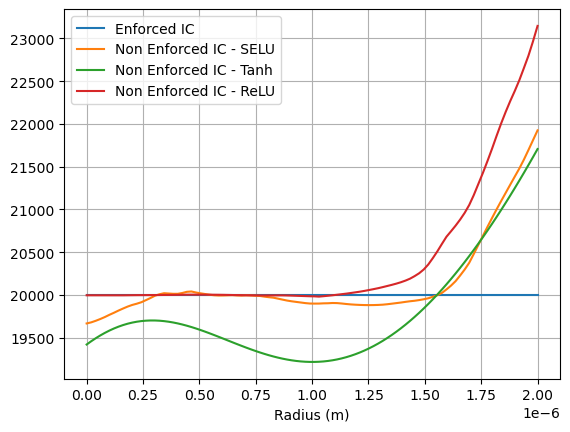

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs_adam = 3000
lr_adam = 1e-4
epochs_lbfgs = 0

pinn = Network(10, 64, 5, 16, nn.SELU, nn.SELU, 100, 100, device).to(device)
pinn2 = Network2(10, 64, 5, 16, nn.SELU, nn.SELU, 100, 100, device).to(device)
pinn3 = Network2(10, 64, 5, 16, nn.Tanh, nn.SELU, 100, 100, device).to(device)
pinn4 = Network2(10, 64, 5, 16, nn.ReLU, nn.SELU, 100, 100, device).to(device)

_, _, _, _ = pinn.train(epochs_adam, lr_adam, epochs_lbfgs)
_, _, _, _ = pinn2.train(epochs_adam, lr_adam, epochs_lbfgs)
_, _, _, _ = pinn3.train(epochs_adam, lr_adam, epochs_lbfgs)
_, _, _, _ = pinn4.train(epochs_adam, lr_adam, epochs_lbfgs)

t0 = torch.tensor(0.).repeat(100).view(-1, 1).requires_grad_(True).to(device)
r = torch.linspace(0, 1, 100).view(-1, 1).requires_grad_(True).to(device)

c1 = pinn.c_max*pinn.forward_c(r, t0).cpu().detach().numpy()
c2 = pinn.c_max*pinn2.forward_c(r, t0).cpu().detach().numpy()
c3 = pinn.c_max*pinn3.forward_c(r, t0).cpu().detach().numpy()
c4 = pinn.c_max*pinn4.forward_c(r, t0).cpu().detach().numpy()

r = pinn.Rs*r.cpu().detach().numpy()

plt.plot(r, c1, label='Enforced IC')
plt.plot(r, c2, label='Non Enforced IC - SELU')
plt.plot(r, c3, label='Non Enforced IC - Tanh')
plt.plot(r, c4, label='Non Enforced IC - ReLU')
plt.legend()
plt.grid(True)
plt.xlabel('Radius (m)')
plt.show()

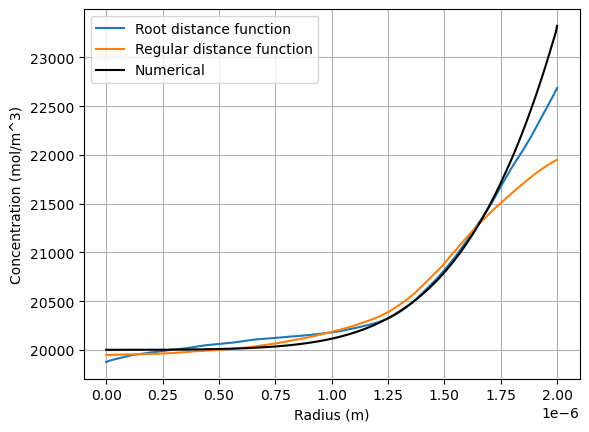

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs_adam = 3000
lr_adam = 1e-4
epochs_lbfgs = 100

pinn = Network(10, 64, 5, 16, nn.SELU, nn.SELU, 100, 100, device).to(device)
pinn2 = Network3(10, 64, 5, 16, nn.SELU, nn.SELU, 100, 100, device).to(device)

_, _, _, _ = pinn.train(epochs_adam, lr_adam, epochs_lbfgs)
_, _, _, _ = pinn2.train(epochs_adam, lr_adam, epochs_lbfgs)

t0 = torch.tensor(0.1).repeat(100).view(-1, 1).requires_grad_(True).to(device)
r = torch.linspace(0, 1, 100).view(-1, 1).requires_grad_(True).to(device)

c1 = pinn.c_max*pinn.forward_c(r, t0).cpu().detach().numpy()
c2 = pinn.c_max*pinn2.forward_c(r, t0).cpu().detach().numpy()

r = pinn.Rs*r.cpu().detach().numpy()

numerical = pd.read_csv("MATLAB Solver\data.csv")
numerical = numerical.iloc[:, 39].to_numpy()
r_numerical = np.linspace(0, 2e-6, 10000)

plt.plot(r, c1, label='Root distance function')
plt.plot(r, c2, label='Regular distance function')
plt.plot(r_numerical, numerical, label='Numerical', color = 'black')

plt.legend()
plt.grid(True)
plt.xlabel('Radius (m)')
plt.ylabel('Concentration (mol/m^3)')

plt.show()

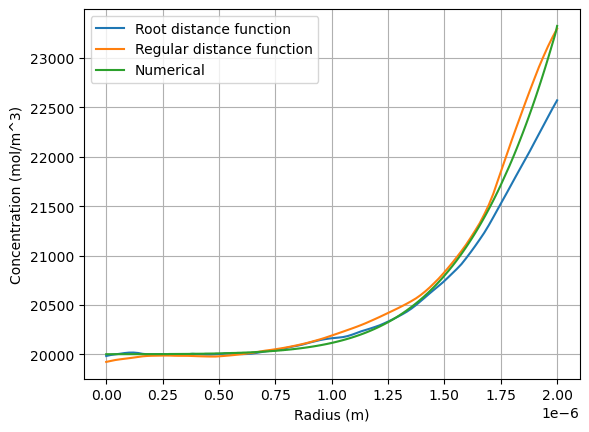

In [42]:
numerical = pd.read_csv("MATLAB Solver\data.csv")
numerical = numerical.iloc[:, 39].to_numpy()
r_numerical = np.linspace(0, 2e-6, 10000)

plt.plot(r, c1, label='Root distance function')
plt.plot(r, c2, label='Regular distance function')
plt.plot(r_numerical, numerical, label='Numerical')

plt.legend()
plt.grid(True)
plt.xlabel('Radius (m)')
plt.ylabel('Concentration (mol/m^3)')

plt.show()

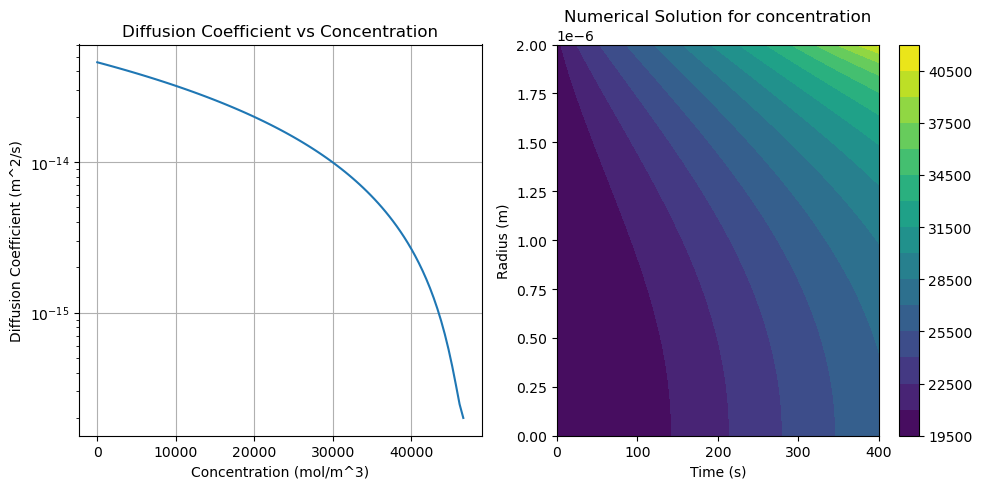

In [10]:
numerical = pd.read_csv("MATLAB Solver\data.csv")
pinn = Network(10, 64, 5, 16, nn.SELU, nn.SELU, 100, 100, device).to(device)
c = pinn.c_max*np.linspace(0, 1, 100).reshape(-1, 1)
D = pinn.Diffusion_Coeff(c)

r = np.linspace(0, 2e-6, 10000)
t = np.linspace(0, 400, 401)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(c, D,)
plt.xlabel('Concentration (mol/m^3)')
plt.ylabel('Diffusion Coefficient (m^2/s)')
plt.title('Diffusion Coefficient vs Concentration')
plt.yscale('log')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.contourf(t, r, numerical, levels = 15)
plt.xlabel('Time (s)')
plt.ylabel('Radius (m)')
plt.title('Numerical Solution for concentration')
plt.colorbar()

plt.tight_layout()
plt.show()

<bound method Figure.tight_layout of <Figure size 1500x500 with 4 Axes>>

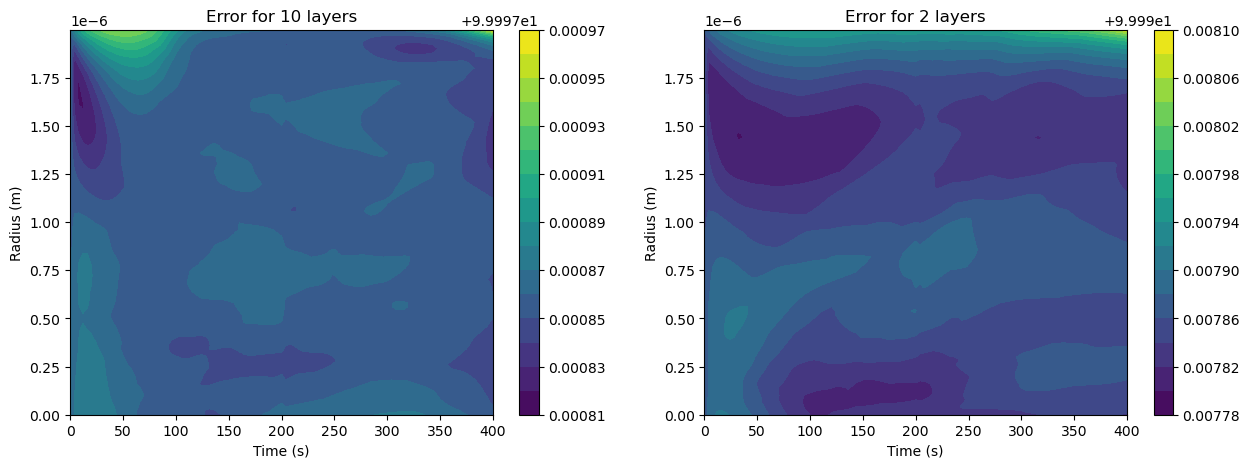

In [36]:
pinn1 = Network(10, 64, 5, 16, nn.SELU, nn.SELU, 100, 100, device).to(device)
pinn2 = Network(2, 64, 5, 16, nn.SELU, nn.SELU, 100, 100, device).to(device)

epochs_adam = 1000
lr_adam = 1e-4
epochs_lbfgs = 0


_, _, _, _ = pinn1.train(epochs_adam, lr_adam, epochs_lbfgs)
_, _, _, _ = pinn2.train(epochs_adam, lr_adam, epochs_lbfgs)



r = torch.linspace(0, 1, 101).to(device).requires_grad_(True)
t = torch.linspace(0, 1, 101).to(device).requires_grad_(True)
r_grid, t_grid = torch.meshgrid(r, t)
c1 = pinn1.forward_c(r_grid.flatten().unsqueeze(1), t_grid.flatten().unsqueeze(1)).view(101, 101).cpu().detach().numpy()
c2 = pinn2.forward_c(r_grid.flatten().unsqueeze(1), t_grid.flatten().unsqueeze(1)).view(101, 101).cpu().detach().numpy()

X_int = np.round(9999*r.cpu().detach().numpy()).astype(int)
T_int = np.round(399*t.cpu().detach().numpy()).astype(int)

numerical = pd.read_csv("MATLAB Solver\data.csv").to_numpy()
numerical = numerical[np.ix_(X_int, T_int)]

r = pinn1.Rs*r.cpu().detach().numpy()
t = 400*t.cpu().detach().numpy()

error = np.absolute((c1 - numerical)/numerical)*100
error2 = np.absolute((c2 - numerical)/numerical)*100

fig = plt.figure(figsize=(15, 5))

# Find the common range for both error and error2
min_value = min(error.min(), error2.min())
max_value = max(error.max(), error2.max())

plt.subplot(1, 2, 1)
plt.contourf(t, r, error, levels=15)
plt.xlabel('Time (s)')
plt.ylabel('Radius (m)')
plt.title('Error for 10 layers')
plt.colorbar()


plt.subplot(1, 2, 2)
contour2 = plt.contourf(t, r, error2, levels=15)
plt.xlabel('Time (s)')
plt.ylabel('Radius (m)')
plt.title('Error for 2 layers')
plt.colorbar(contour2)

fig.tight_layout

In [3]:
class Network_outer_test(nn.Module):

  def __init__(self, width, depth, width_D, depth_D, activation, D_activation, N, N_data, device):
    super().__init__()
    # optimisers    

    # constants and stuff
    device = device
    self.N = N
    self.N_data = N_data
    self.r_data, self.t_data = self.sample(self.N_data)
    self.c_numerical = torch.tensor(self.NumericalSoln(self.r_data.cpu().detach().numpy(), self.t_data.cpu().detach().numpy())).to(device)
    self.r0_boundary, self.rs_boundary, self.t_boundaries, self.t0_boundary, self.r_boundary = self.init_boundaries(N)
    self.j = -5.35e-5
    self.Rs = torch.tensor(2e-6)
    self.c_max = 4.665e4
    self.c0 = torch.tensor(2e4).view(-1, 1).to(device)
    self.D_ref = 2e-16
    self.C_theory = 277.84
    self.C_practical = 160

    # storing D and loss values
    self.Ds = []
    self.loss_list = []
    self.r0_loss_list = []
    self.rs_loss_list = []
    self.phys_loss_list = []
    self.comp_loss_list = []

    # nn constants
    #activation = nn.SELU
    #D_activation = nn.Tanh
    self.D_hidden = depth_D # number of neurons in hidden layers for D
    self.D_layers = width_D # number of hidden layers for D
    self.input = 2 # input is r and t
    self.output = 1 # output is c
    self.layers = width # number of hidden layers
    self.hidden = depth # number of neurons in hidden layers
    self.activation = activation

    # c network
    self.fci = nn.Sequential(*[nn.Linear(self.input, self.hidden), activation()])
    init.kaiming_normal_(self.fci[0].weight, nonlinearity='tanh')
    self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(self.hidden, self.hidden), activation()]) for i in range(self.layers-1)])
    for layer in self.fch.children():
      if isinstance(layer, nn.Linear):
          init.kaiming_normal_(layer.weight, nonlinearity='tanh')
    self.fco = nn.Linear(self.hidden, self.output)

    # D network
    self.fciD = nn.Sequential(*[nn.Linear(1, self.D_hidden), D_activation()])
    init.kaiming_normal_(self.fciD[0].weight)
    self.fchD = nn.Sequential(*[nn.Sequential(*[nn.Linear(self.D_hidden, self.D_hidden), D_activation()]) for i in range(self.D_layers-1)])
    for layer in self.fchD.children():
      if isinstance(layer, nn.Linear):
          init.kaiming_normal_(layer.weight)
    self.fcoD = nn.Linear(self.D_hidden, 1)

  # c forward propagation
  def forward_c(self, x, t):
    x = torch.cat((x, t), dim = 1)
    x = self.fci(x)
    x = self.fch(x)
    x = self.fco(x)
    x = self.c0/self.c_max + t**0.5*x
    return x
  
  # D forward propagation
  def forward_D(self, x):
    x = self.fciD(x)
    x = self.fchD(x)
    x = self.fcoD(x)
    x = x*1e-13
    return x
  
  # numerical solution of spherical diffusion equation
  def NumericalSoln(self, r_data, t_data):

    numerical_sol = pd.read_csv("MATLAB Solver\data.csv")
    
    sol = []
    for i in range(len(r_data)):
      r = np.round(9999 * r_data[i]).astype(int)[0]
      t = np.round(200 * t_data[i]).astype(int)[0]  
      
      c = numerical_sol.iloc[r, t]
      sol.append(c)
    return sol
  
  
  def init_boundaries(self, N):

    # x and t boundary points for training x boundaries, x = 0,1, varying t values
    r0_boundary = torch.tensor(0.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    rs_boundary = torch.tensor(1.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    t_boundaries = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)

    # 0 time boundary for training
    t0_boundary = torch.tensor(0.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    r_boundary = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)

    return r0_boundary, rs_boundary, t_boundaries, t0_boundary, r_boundary

  def sample(self, N):
        
    # sample points for training
    r = torch.rand(N).view(-1, 1).requires_grad_(True).to(device).view(-1, 1)
    t = torch.rand(N).view(-1, 1).requires_grad_(True).to(device).view(-1, 1)

    return r, t

# adaptive sampling, unused due to VRAM limitations
  def adaptive_sample(self, N):
    
    r = torch.linspace(0.01, 0.99999, 2*N).requires_grad_(True).to(device)
    t = torch.linspace(0.01, 0.99999, 2*N).requires_grad_(True).to(device)
    r_grid, t_grid = torch.meshgrid(r, t)
    phys_loss = self.phys_loss(r_grid.flatten().unsqueeze(1), t_grid.flatten().unsqueeze(1)).view(2*N, 2*N)

    phys_loss_r = torch.mean(phys_loss, dim=1)
    phys_loss_t = torch.mean(phys_loss, dim=0)
    
    plt.plot(phys_loss_r.cpu().detach().numpy(), label='r')
    plt.plot(phys_loss_t.cpu().detach().numpy(), label='t')
    plt.legend()

    r_ids = torch.multinomial(phys_loss_r, N, replacement=False)
    t_ids = torch.multinomial(phys_loss_t, N, replacement=False)
    r = r[r_ids]
    t = t[t_ids]

    return r, t

  def Diffusion_Coeff(self, c):

    SOC = (self.c_max - c)/self.c_max * self.C_theory/self.C_practical
    D = self.D_ref * (1 + 100*SOC**(3/2))

    return D
  
  def deriv_t(self, c, t):
    return torch.autograd.grad(c, t, grad_outputs=torch.ones_like(c).to(device), create_graph=True)[0]
  
  def deriv_r(self, c, r):
    return torch.autograd.grad(c, r, grad_outputs=torch.ones_like(c).to(device), create_graph=True)[0]
  
  def phys_loss(self, r, t):

    Rs = self.Rs
    c = self.forward_c(r, t)
    c_r = self.deriv_r(c, r)
    c_rr = self.deriv_r(c_r, r)
    c_t = self.deriv_t(c, t)
    D = self.forward_D(c)
    D_r = self.deriv_r(D, r)
    term = r**2*D*c_r/(Rs**2)
    deriv = self.deriv_r(term, r)

    #loss = (r**2*c_t - (2*r*c_r - D*r**2*c_rr - D_r*r**2*c_r)/(Rs**2))**2
    loss = (r**2*c_t - deriv)**2
    return loss

  def losses(self):
    
    r_phys, t_phys = self.sample(self.N)
    j, Rs, c_max, c0 = self.j, self.Rs, self.c_max, self.c0 

    # loss for r = 0 boundary
    c = self.forward_c(self.r0_boundary, self.t_boundaries)
    c_r = self.deriv_r(c, self.r0_boundary)
    r0_loss = c_r**2
    self.r0_loss_list.append(torch.mean(r0_loss).item())
    
    # loss for x = rs boundary
    c = self.forward_c(self.rs_boundary, self.t_boundaries)
    c_r = self.deriv_r(c, self.rs_boundary)
    D = self.forward_D(c)
    rs_loss = (D*c_r + j*Rs/c_max)**2
    self.rs_loss_list.append(torch.mean(rs_loss).item())

    # physics loss
    phys_loss = self.phys_loss(r_phys, t_phys)
    self.phys_loss_list.append(torch.mean(phys_loss).item())
    
    # comparative loss
    c = self.c_max*self.forward_c(self.r_data, self.t_data)
    comp_loss = 1/self.c_max*(torch.sub(c, self.c_numerical.unsqueeze(1)))**2
    self.comp_loss_list.append(torch.mean(comp_loss).item())

    loss = torch.mean(r0_loss) + 1e28*torch.mean(rs_loss) + 100*torch.mean(phys_loss) + 100*torch.mean(comp_loss)

    return loss
  
  def closure(self):
    self.optimizer_lbfgs.zero_grad()
    loss = self.losses()
    loss.backward()
    return loss
  
  def train(self, epochs_adam, lr_adam, epochs_lbfgs):

    # Adam
    optimizer_adam = torch.optim.Adam(self.parameters(), lr = lr_adam)
    times = []

    for epoch in range(epochs_adam):
      
      start_time = time.perf_counter()
      self.epoch = epoch
      
      optimizer_adam.zero_grad()
      loss = self.losses()
      self.loss_list.append(loss.item())
      loss.backward()
      optimizer_adam.step()
      #print(f'Epoch: {epoch}  Loss: {loss.item()}', end='\r')
      print(f'Activation: {self.activation.__name__}, Width: {self.layers}  Depth: {self.hidden}, D_Width: {self.D_layers}, D_Depth: {self.D_hidden},  Epoch: {self.epoch}  Loss: {loss.item()}', end='\r')
      end_time = time.perf_counter()
      times.append(end_time - start_time)


    # LBFGS
    self.optimizer_lbfgs = torch.optim.LBFGS(self.parameters(), 
                                        max_iter=400, 
                                        history_size=400, 
                                        tolerance_grad=1.0 * np.finfo(float).eps, 
                                        tolerance_change=1.0 * np.finfo(float).eps, 
                                        line_search_fn='strong_wolfe')
    for epoch in range(epochs_lbfgs):

      start_time = time.perf_counter()
      loss = self.optimizer_lbfgs.step(self.closure)
      self.loss_list.append(loss.item())

      self.epoch = epochs_adam + epoch

      if np.isnan(loss.item()):
        break
      end_time = time.perf_counter()
      times.append(end_time - start_time)
      print(f'Activation: {self.activation.__name__}, Width: {self.layers}  Depth: {self.hidden}, D_Width: {self.D_layers}, D_Depth: {self.D_hidden},  Epoch: {self.epoch}  Loss: {loss.item()}', end='\r')
      

    error_D = self.error_D()
    error_c = self.error()

    return self.loss_list, error_D, error_c, times

  def plot(self):

      X = torch.linspace(0, 1, 100).to(device)
      T = torch.linspace(0, 1, 100).to(device)
      X_grid, T_grid = torch.meshgrid(X, T)
      
      C = self.c_max*self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
      C = C.view(100, 100)
      C = C.cpu().detach().numpy()
      
      X, T = np.meshgrid(self.Rs*X.cpu().detach().numpy(), 400*T.cpu().detach().numpy())

      fig = go.Figure(data=[go.Surface(z=C, x=X, y=T)])
      fig.update_layout(template = 'plotly_dark', 
                        title='Concentration vs Time and Radius', 
                        scene = dict(xaxis = dict(title = 'Radius'),
                        yaxis = dict(title = 'Time (s)'),
                        zaxis = dict(title = 'Concentration')),                        
                        autosize=False, width=800, height=600, margin=dict(l=50, r=50, t=50, b=50))
      fig.show()

  def error_D(self):

    c = torch.linspace(0, 1, 100).view(-1, 1).to(device)
    D = self.forward_D(c).cpu().detach().numpy()
    c = self.c_max*c.cpu().detach().numpy()
    D_SOC = self.Diffusion_Coeff(c)

    error_D = np.mean(np.sqrt((D - D_SOC)**2))

    return error_D

  def plot_loss(self):
    fig = px.scatter(
            x=range(len(self.loss_list)),
            y=self.loss_list,
            log_y=True,
            log_x=True,
            color=np.log(self.loss_list),
            color_continuous_scale="Agsunset",
            labels={"x": "Epochs", "y": "Loss"},
            template='plotly_dark'
        )
    fig.show()

    plt.plot(self.r0_loss_list, label='r0_loss')
    plt.plot(self.rs_loss_list, label='rs_loss')
    plt.plot(self.phys_loss_list, label='phys_loss')
    #plt.plot(self.comp_loss_list, label='comp_loss')
    plt.legend()
    plt.show()

  def plot_comparison(self):

    numerical = pd.read_csv("MATLAB Solver\data.csv")
    X = torch.linspace(0, 1, 100).to(device).requires_grad_(True)
    T = torch.linspace(0, 1, 100).to(device).requires_grad_(True)
    X_grid, T_grid = torch.meshgrid(X, T)

    C = self.c_max*self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
    C = C.view(100, 100)
    C = C.cpu().detach().numpy()

    X = np.round(10000*X.cpu().detach().numpy())
    T = np.round(400*T.cpu().detach().numpy())

    fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{}, {}]], subplot_titles=('Comparison at t=0', 'Comparison at t=end', 'Comparison at r=0', 'Comparison at r=end'))

    fig.add_trace(go.Scatter(y=numerical.iloc[:, 0], mode='lines', name='Numerical', showlegend=True, line=dict(color="#2EBFA5")), row=1, col=1)
    fig.add_trace(go.Scatter(x=X, y=C[:, 0], mode='lines', name='NN', showlegend=True, line=dict(color="#3590F3")), row=1, col=1)

    fig.add_trace(go.Scatter(y=numerical.iloc[:, -1], mode='lines', name='Numerical', showlegend=False, line=dict(color="#2EBFA5")), row=1, col=2)
    fig.add_trace(go.Scatter(x=X, y=C[:, -1], mode='lines', name='NN', showlegend=False, line=dict(color="#3590F3")), row=1, col=2)

    fig.add_trace(go.Scatter(y=numerical.iloc[0, :], mode='lines', name='Numerical', showlegend=False, line=dict(color="#2EBFA5")), row=2, col=1)
    fig.add_trace(go.Scatter(x=T, y=C[0, :], mode='lines', name='NN', showlegend=False, line=dict(color="#3590F3")), row=2, col=1)

    fig.add_trace(go.Scatter(y=numerical.iloc[-1, :], mode='lines', name='Numerical', showlegend=False, line=dict(color="#2EBFA5")), row=2, col=2)
    fig.add_trace(go.Scatter(x=T, y=C[-1, :], mode='lines', name='NN', showlegend=False, line=dict(color="#3590F3")), row=2, col=2)

    fig.update_layout(autosize=False, width=800, height=600, margin=dict(l=50, r=50, t=50, b=50), showlegend=True, template = 'plotly_dark')

    fig.show()
      
  def error(self):
    
    X = torch.linspace(0, 0.99, 101).to(device).requires_grad_(True)
    T = torch.linspace(0, 0.99, 101).to(device).requires_grad_(True)
    X_grid, T_grid = torch.meshgrid(X, T)
    C = self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
    C = self.c_max*C.view(101, 101)
    X_int = np.round(10000*X.cpu().detach().numpy()).astype(int)
    T_int = np.round(400*T.cpu().detach().numpy()).astype(int)

    numerical = pd.read_csv("MATLAB Solver\data.csv").to_numpy()
    numerical = numerical[np.ix_(X_int, T_int)]

    abs_error = np.mean(np.sqrt((numerical - C.cpu().detach().numpy())**2))
    
    return abs_error
    


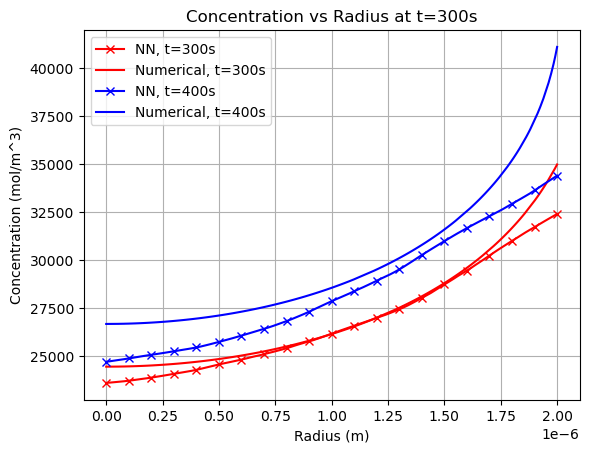

In [86]:
# beyond
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs_adam = 3000
lr_adam = 1e-4
epochs_lbfgs = 50

pinn = Network_outer_test(10, 64, 5, 16, nn.SELU, nn.SELU, 100, 100, device).to(device)

_, _, _, _ = pinn.train(epochs_adam, lr_adam, epochs_lbfgs)

r = torch.linspace(0, 1, 101).view(-1, 1).to(device).requires_grad_(True)
t = torch.tensor(1.5).repeat(101).view(-1, 1).requires_grad_(True).to(device)
t2 = torch.tensor(2.).repeat(101).view(-1, 1).requires_grad_(True).to(device)

c = pinn.c_max*pinn.forward_c(r, t).cpu().detach().numpy()
c2 = pinn.c_max*pinn.forward_c(r, t2).cpu().detach().numpy()

numerical = pd.read_csv("MATLAB Solver\data.csv")
numerical1 = numerical.iloc[:, 300].to_numpy()
numerical2 = numerical.iloc[:, 400].to_numpy()

r = pinn.Rs*r.cpu().detach().numpy()
r_numerical = np.linspace(0, 2e-6, 10000)

plt.plot(r, c, label='NN, t=300s', marker = 'x', color = 'red', markevery=5)
plt.plot(r_numerical, numerical1, label='Numerical, t=300s', color = 'red', markevery=100)
plt.plot(r, c2, label='NN, t=400s', marker = 'x', color = 'blue', markevery=5)
plt.plot(r_numerical, numerical2, label='Numerical, t=400s', color = 'blue', markevery=100)
plt.legend()
plt.grid(True)
plt.xlabel('Radius (m)')
plt.ylabel('Concentration (mol/m^3)')
plt.title('Concentration vs Radius at t=300s')
plt.show()


In [53]:
class Network_noise(nn.Module):

  def __init__(self, width, depth, width_D, depth_D, activation, D_activation, N, N_data, noise_level, device):
    super().__init__()
    # optimisers    

    # constants and stuff
    device = device
    self.N = N
    self.N_data = N_data
    self.noise_level = noise_level
    self.r_data, self.t_data = self.sample(self.N_data)
    self.c_numerical = torch.tensor(self.NumericalSoln(self.r_data.cpu().detach().numpy(), self.t_data.cpu().detach().numpy())).to(device)
    self.r0_boundary, self.rs_boundary, self.t_boundaries, self.t0_boundary, self.r_boundary = self.init_boundaries(N)
    self.j = -5.35e-5
    self.Rs = torch.tensor(2e-6)
    self.c_max = 4.665e4
    self.c0 = torch.tensor(2e4).view(-1, 1).to(device)
    self.D_ref = 2e-16
    self.C_theory = 277.84
    self.C_practical = 160

    # storing D and loss values
    self.Ds = []
    self.loss_list = []
    self.r0_loss_list = []
    self.rs_loss_list = []
    self.phys_loss_list = []
    self.comp_loss_list = []

    # nn constants
    #activation = nn.SELU
    #D_activation = nn.Tanh
    self.D_hidden = depth_D # number of neurons in hidden layers for D
    self.D_layers = width_D # number of hidden layers for D
    self.input = 2 # input is r and t
    self.output = 1 # output is c
    self.layers = width # number of hidden layers
    self.hidden = depth # number of neurons in hidden layers
    self.activation = activation

    # c network
    self.fci = nn.Sequential(*[nn.Linear(self.input, self.hidden), activation()])
    init.kaiming_normal_(self.fci[0].weight, nonlinearity='tanh')
    self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(self.hidden, self.hidden), activation()]) for i in range(self.layers-1)])
    for layer in self.fch.children():
      if isinstance(layer, nn.Linear):
          init.kaiming_normal_(layer.weight, nonlinearity='tanh')
    self.fco = nn.Linear(self.hidden, self.output)

    # D network
    self.fciD = nn.Sequential(*[nn.Linear(1, self.D_hidden), D_activation()])
    init.kaiming_normal_(self.fciD[0].weight)
    self.fchD = nn.Sequential(*[nn.Sequential(*[nn.Linear(self.D_hidden, self.D_hidden), D_activation()]) for i in range(self.D_layers-1)])
    for layer in self.fchD.children():
      if isinstance(layer, nn.Linear):
          init.kaiming_normal_(layer.weight)
    self.fcoD = nn.Linear(self.D_hidden, 1)

  # c forward propagation
  def forward_c(self, x, t):
    x = torch.cat((x, t), dim = 1)
    x = self.fci(x)
    x = self.fch(x)
    x = self.fco(x)
    x = self.c0/self.c_max + t**0.5*x
    return x
  
  # D forward propagation
  def forward_D(self, x):
    x = self.fciD(x)
    x = self.fchD(x)
    x = self.fcoD(x)
    x = x*1e-13
    return x
  
  # numerical solution of spherical diffusion equation
  def NumericalSoln(self, r_data, t_data):

    numerical_sol = pd.read_csv("MATLAB Solver\data.csv")
    
    sol = []
    for i in range(len(r_data)):
      r = np.round(9999 * r_data[i]).astype(int)[0]
      t = np.round(399 * t_data[i]).astype(int)[0]  
      
      c = numerical_sol.iloc[r, t]
      noise = np.random.normal(0, self.noise_level*c)
      sol.append(c+noise)
    return sol
  
  
  def init_boundaries(self, N):

    # x and t boundary points for training x boundaries, x = 0,1, varying t values
    r0_boundary = torch.tensor(0.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    rs_boundary = torch.tensor(1.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    t_boundaries = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)

    # 0 time boundary for training
    t0_boundary = torch.tensor(0.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    r_boundary = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)

    return r0_boundary, rs_boundary, t_boundaries, t0_boundary, r_boundary

  def sample(self, N):
        
    # sample points for training
    r = torch.rand(N).view(-1, 1).requires_grad_(True).to(device).view(-1, 1)
    t = torch.rand(N).view(-1, 1).requires_grad_(True).to(device).view(-1, 1)

    return r, t

# adaptive sampling, unused due to VRAM limitations
  def adaptive_sample(self, N):
    
    r = torch.linspace(0.01, 0.99999, 2*N).requires_grad_(True).to(device)
    t = torch.linspace(0.01, 0.99999, 2*N).requires_grad_(True).to(device)
    r_grid, t_grid = torch.meshgrid(r, t)
    phys_loss = self.phys_loss(r_grid.flatten().unsqueeze(1), t_grid.flatten().unsqueeze(1)).view(2*N, 2*N)

    phys_loss_r = torch.mean(phys_loss, dim=1)
    phys_loss_t = torch.mean(phys_loss, dim=0)
    
    plt.plot(phys_loss_r.cpu().detach().numpy(), label='r')
    plt.plot(phys_loss_t.cpu().detach().numpy(), label='t')
    plt.legend()

    r_ids = torch.multinomial(phys_loss_r, N, replacement=False)
    t_ids = torch.multinomial(phys_loss_t, N, replacement=False)
    r = r[r_ids]
    t = t[t_ids]

    return r, t

  def Diffusion_Coeff(self, c):

    SOC = (self.c_max - c)/self.c_max * self.C_theory/self.C_practical
    D = self.D_ref * (1 + 100*SOC**(3/2))

    return D
  
  def deriv_t(self, c, t):
    return torch.autograd.grad(c, t, grad_outputs=torch.ones_like(c).to(device), create_graph=True)[0]
  
  def deriv_r(self, c, r):
    return torch.autograd.grad(c, r, grad_outputs=torch.ones_like(c).to(device), create_graph=True)[0]
  
  def phys_loss(self, r, t):

    Rs = self.Rs
    c = self.forward_c(r, t)
    c_r = self.deriv_r(c, r)
    c_rr = self.deriv_r(c_r, r)
    c_t = self.deriv_t(c, t)
    D = self.forward_D(c)
    D_r = self.deriv_r(D, r)
    term = r**2*D*c_r/(Rs**2)
    deriv = self.deriv_r(term, r)

    #loss = (r**2*c_t - (2*r*c_r - D*r**2*c_rr - D_r*r**2*c_r)/(Rs**2))**2
    loss = (r**2*c_t - deriv)**2
    return loss

  def losses(self):
    
    r_phys, t_phys = self.sample(self.N)
    j, Rs, c_max, c0 = self.j, self.Rs, self.c_max, self.c0 

    # loss for r = 0 boundary
    c = self.forward_c(self.r0_boundary, self.t_boundaries)
    c_r = self.deriv_r(c, self.r0_boundary)
    r0_loss = c_r**2
    self.r0_loss_list.append(torch.mean(r0_loss).item())
    
    # loss for x = rs boundary
    c = self.forward_c(self.rs_boundary, self.t_boundaries)
    c_r = self.deriv_r(c, self.rs_boundary)
    D = self.forward_D(c)
    rs_loss = (D*c_r + j*Rs/c_max)**2
    self.rs_loss_list.append(torch.mean(rs_loss).item())

    # physics loss
    phys_loss = self.phys_loss(r_phys, t_phys)
    self.phys_loss_list.append(torch.mean(phys_loss).item())
    
    # comparative loss
    c = self.c_max*self.forward_c(self.r_data, self.t_data)
    comp_loss = 1/self.c_max*(torch.sub(c, self.c_numerical.unsqueeze(1)))**2
    self.comp_loss_list.append(torch.mean(comp_loss).item())

    loss = torch.mean(r0_loss) + 1e28*torch.mean(rs_loss) + 100*torch.mean(phys_loss) + 100*torch.mean(comp_loss)

    return loss
  
  def closure(self):
    self.optimizer_lbfgs.zero_grad()
    loss = self.losses()
    loss.backward()
    return loss
  
  def train(self, epochs_adam, lr_adam, epochs_lbfgs):

    # Adam
    optimizer_adam = torch.optim.Adam(self.parameters(), lr = lr_adam)
    times = []

    for epoch in range(epochs_adam):
      
      start_time = time.perf_counter()
      self.epoch = epoch
      
      optimizer_adam.zero_grad()
      loss = self.losses()
      self.loss_list.append(loss.item())
      loss.backward()
      optimizer_adam.step()
      #print(f'Epoch: {epoch}  Loss: {loss.item()}', end='\r')
      print(f'Activation: {self.activation.__name__}, Width: {self.layers}  Depth: {self.hidden}, D_Width: {self.D_layers}, D_Depth: {self.D_hidden},  Epoch: {self.epoch}  Loss: {loss.item()}', end='\r')
      end_time = time.perf_counter()
      times.append(end_time - start_time)


    # LBFGS
    self.optimizer_lbfgs = torch.optim.LBFGS(self.parameters(), 
                                        max_iter=400, 
                                        history_size=400, 
                                        tolerance_grad=1.0 * np.finfo(float).eps, 
                                        tolerance_change=1.0 * np.finfo(float).eps, 
                                        line_search_fn='strong_wolfe')
    for epoch in range(epochs_lbfgs):

      start_time = time.perf_counter()
      loss = self.optimizer_lbfgs.step(self.closure)
      self.loss_list.append(loss.item())

      self.epoch = epochs_adam + epoch

      if np.isnan(loss.item()):
        break
      end_time = time.perf_counter()
      times.append(end_time - start_time)
      print(f'Activation: {self.activation.__name__}, Width: {self.layers}  Depth: {self.hidden}, D_Width: {self.D_layers}, D_Depth: {self.D_hidden},  Epoch: {self.epoch}  Loss: {loss.item()}', end='\r')
      

    error_D = self.error_D()
    error_c = self.error()

    return self.loss_list, error_D, error_c, times

  def plot(self):

      X = torch.linspace(0, 1, 100).to(device)
      T = torch.linspace(0, 1, 100).to(device)
      X_grid, T_grid = torch.meshgrid(X, T)
      
      C = self.c_max*self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
      C = C.view(100, 100)
      C = C.cpu().detach().numpy()
      
      X, T = np.meshgrid(self.Rs*X.cpu().detach().numpy(), 400*T.cpu().detach().numpy())

      fig = go.Figure(data=[go.Surface(z=C, x=X, y=T)])
      fig.update_layout(template = 'plotly_dark', 
                        title='Concentration vs Time and Radius', 
                        scene = dict(xaxis = dict(title = 'Radius'),
                        yaxis = dict(title = 'Time (s)'),
                        zaxis = dict(title = 'Concentration')),                        
                        autosize=False, width=800, height=600, margin=dict(l=50, r=50, t=50, b=50))
      fig.show()

  def error_D(self):

    c = torch.linspace(0, 1, 100).view(-1, 1).to(device)
    D = self.forward_D(c).cpu().detach().numpy()
    c = self.c_max*c.cpu().detach().numpy()
    D_SOC = self.Diffusion_Coeff(c)

    error_D = np.mean(np.sqrt((D - D_SOC)**2))

    return error_D


  def plot_loss(self):
    fig = px.scatter(
            x=range(len(self.loss_list)),
            y=self.loss_list,
            log_y=True,
            log_x=True,
            color=np.log(self.loss_list),
            color_continuous_scale="Agsunset",
            labels={"x": "Epochs", "y": "Loss"},
            template='plotly_dark'
        )
    fig.show()

    plt.plot(self.r0_loss_list, label='r0_loss')
    plt.plot(self.rs_loss_list, label='rs_loss')
    plt.plot(self.phys_loss_list, label='phys_loss')
    #plt.plot(self.comp_loss_list, label='comp_loss')
    plt.legend()
    plt.show()

  def plot_comparison(self):

    numerical = pd.read_csv("MATLAB Solver\data.csv")
    X = torch.linspace(0, 1, 100).to(device).requires_grad_(True)
    T = torch.linspace(0, 1, 100).to(device).requires_grad_(True)
    X_grid, T_grid = torch.meshgrid(X, T)

    C = self.c_max*self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
    C = C.view(100, 100)
    C = C.cpu().detach().numpy()

    X = np.round(10000*X.cpu().detach().numpy())
    T = np.round(400*T.cpu().detach().numpy())

    fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{}, {}]], subplot_titles=('Comparison at t=0', 'Comparison at t=end', 'Comparison at r=0', 'Comparison at r=end'))

    fig.add_trace(go.Scatter(y=numerical.iloc[:, 0], mode='lines', name='Numerical', showlegend=True, line=dict(color="#2EBFA5")), row=1, col=1)
    fig.add_trace(go.Scatter(x=X, y=C[:, 0], mode='lines', name='NN', showlegend=True, line=dict(color="#3590F3")), row=1, col=1)

    fig.add_trace(go.Scatter(y=numerical.iloc[:, -1], mode='lines', name='Numerical', showlegend=False, line=dict(color="#2EBFA5")), row=1, col=2)
    fig.add_trace(go.Scatter(x=X, y=C[:, -1], mode='lines', name='NN', showlegend=False, line=dict(color="#3590F3")), row=1, col=2)

    fig.add_trace(go.Scatter(y=numerical.iloc[0, :], mode='lines', name='Numerical', showlegend=False, line=dict(color="#2EBFA5")), row=2, col=1)
    fig.add_trace(go.Scatter(x=T, y=C[0, :], mode='lines', name='NN', showlegend=False, line=dict(color="#3590F3")), row=2, col=1)

    fig.add_trace(go.Scatter(y=numerical.iloc[-1, :], mode='lines', name='Numerical', showlegend=False, line=dict(color="#2EBFA5")), row=2, col=2)
    fig.add_trace(go.Scatter(x=T, y=C[-1, :], mode='lines', name='NN', showlegend=False, line=dict(color="#3590F3")), row=2, col=2)

    fig.update_layout(autosize=False, width=800, height=600, margin=dict(l=50, r=50, t=50, b=50), showlegend=True, template = 'plotly_dark')

    fig.show()
      
  def error(self):
    
    X = torch.linspace(0, 0.99, 101).to(device).requires_grad_(True)
    T = torch.linspace(0, 0.99, 101).to(device).requires_grad_(True)
    X_grid, T_grid = torch.meshgrid(X, T)
    C = self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
    C = self.c_max*C.view(101, 101)
    X_int = np.round(10000*X.cpu().detach().numpy()).astype(int)
    T_int = np.round(400*T.cpu().detach().numpy()).astype(int)

    numerical = pd.read_csv("MATLAB Solver\data.csv").to_numpy()
    numerical = numerical[np.ix_(X_int, T_int)]

    abs_error = np.mean(np.sqrt((numerical - C.cpu().detach().numpy())**2))
    
    return abs_error
    


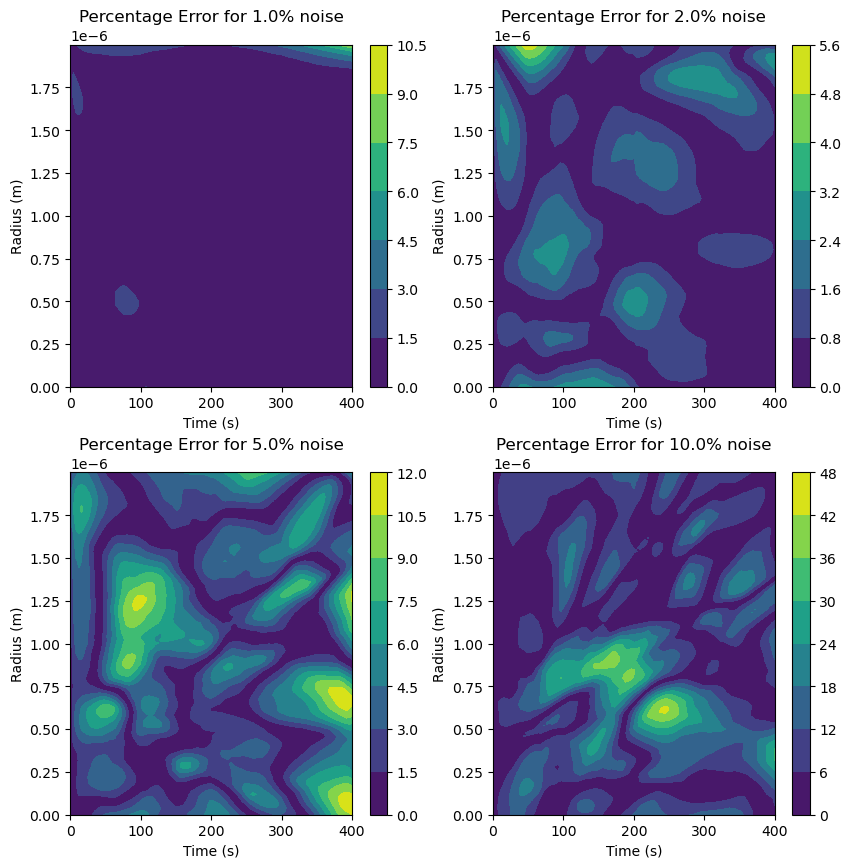

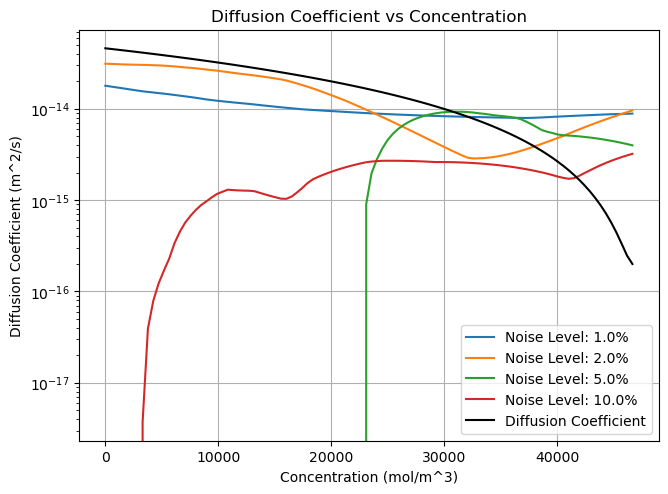

In [79]:
# noise
r = torch.linspace(0, 1, 101).to(device).requires_grad_(True)
t = torch.linspace(0, 1, 101).to(device).requires_grad_(True)
r_grid, t_grid = torch.meshgrid(r, t)
r_plot = 2e-6*r.cpu().detach().numpy()
t_plot = 400*t.cpu().detach().numpy()
X_int = np.round(9999*r.cpu().detach().numpy()).astype(int)
T_int = np.round(399*t.cpu().detach().numpy()).astype(int)

numerical = pd.read_csv("MATLAB Solver\data.csv").to_numpy()
numerical = numerical[np.ix_(X_int, T_int)]

cD= torch.linspace(0, 1, 100).view(-1, 1).to(device).requires_grad_(True)
cD_plot = 4.665e4*cD.cpu().detach().numpy()

epochs_adam = 3000
lr_adam = 1e-4
epochs_lbfgs = 50

fig1, axes = plt.subplots(2, 2, figsize=(10, 10))
fig1.subplots_adjust(hspace=0.25)
fig2 = plt.figure()

i = 0

for noise_level in [0.01, 0.02, 0.05, 0.1]:
    
    
    pinn= Network_noise(10, 64, 5, 16, nn.SELU, nn.SELU, 100, 100, noise_level, device).to(device)
    _, _, _, _ = pinn.train(epochs_adam, lr_adam, epochs_lbfgs)


    fig2
    D = pinn.forward_D(cD).cpu().detach().numpy()
    plt.plot(cD_plot, D, label=f'Noise Level: {100*noise_level}%')



    c = pinn.c_max*pinn.forward_c(r_grid.flatten().unsqueeze(1), t_grid.flatten().unsqueeze(1))
    c = c.view(101, 101)
    c = c.cpu().detach().numpy()

    error = np.abs((numerical - c)/numerical)*100

    contour = axes[i // 2, i % 2].contourf(t_plot, r_plot, error, cmap='viridis')
    plt.colorbar(contour, ax = axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_ylabel('Radius (m)')
    axes[i // 2, i % 2].set_xlabel('Time (s)')
    axes[i // 2, i % 2].set_title(f'Percentage Error for {100*noise_level}% noise')

    i += 1

plt.tight_layout()
fig2
D_SOC = pinn.Diffusion_Coeff(cD_plot)
plt.plot(cD_plot, D_SOC, label='Diffusion Coefficient', color = 'black')
plt.legend()
plt.grid(True)
plt.xlabel('Concentration (mol/m^3)')
plt.ylabel('Diffusion Coefficient (m^2/s)')
plt.title('Diffusion Coefficient vs Concentration')
plt.yscale('log')



    






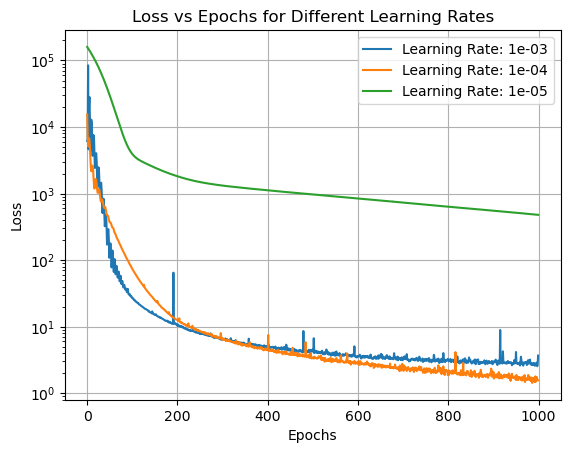

In [82]:
# learning rates
lrs = [1e-3, 1e-4, 1e-5]
epochs_adam = 1000
epochs_lbfgs = 0

for lr in lrs:
    pinn = Network(10, 64, 5, 16, nn.SELU, nn.SELU, 100, 100, device).to(device)
    losses, _, _, _ = pinn.train(epochs_adam, lr, epochs_lbfgs)
    plt.plot(losses, label=f'Learning Rate: {lr:.0e}')

plt.legend()
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.title('Loss vs Epochs for Different Learning Rates')
plt.show()


In [102]:
class beyond(nn.Module):

  def __init__(self, width, depth, width_D, depth_D, activation, D_activation, N, N_data, device):
    super().__init__()
    # optimisers    

    # constants and stuff
    device = device
    self.N = N
    self.N_data = N_data
    self.r_data, self.t_data = self.sample_data(self.N_data)
    self.c_numerical = torch.tensor(self.NumericalSoln(self.r_data.cpu().detach().numpy(), self.t_data.cpu().detach().numpy())).to(device)
    self.r0_boundary, self.rs_boundary, self.t_boundaries, self.t0_boundary, self.r_boundary = self.init_boundaries(N)
    self.j = -5.35e-5
    self.Rs = torch.tensor(2e-6)
    self.c_max = 4.665e4
    self.c0 = torch.tensor(2e4).view(-1, 1).to(device)
    self.D_ref = 2e-16
    self.C_theory = 277.84
    self.C_practical = 160

    # storing D and loss values
    self.Ds = []
    self.loss_list = []
    self.r0_loss_list = []
    self.rs_loss_list = []
    self.phys_loss_list = []
    self.comp_loss_list = []

    # nn constants
    #activation = nn.SELU
    #D_activation = nn.Tanh
    self.D_hidden = depth_D # number of neurons in hidden layers for D
    self.D_layers = width_D # number of hidden layers for D
    self.input = 2 # input is r and t
    self.output = 1 # output is c
    self.layers = width # number of hidden layers
    self.hidden = depth # number of neurons in hidden layers
    self.activation = activation

    # c network
    self.fci = nn.Sequential(*[nn.Linear(self.input, self.hidden), activation()])
    init.kaiming_normal_(self.fci[0].weight, nonlinearity='tanh')
    self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(self.hidden, self.hidden), activation()]) for i in range(self.layers-1)])
    for layer in self.fch.children():
      if isinstance(layer, nn.Linear):
          init.kaiming_normal_(layer.weight, nonlinearity='tanh')
    self.fco = nn.Linear(self.hidden, self.output)

    # D network
    self.fciD = nn.Sequential(*[nn.Linear(1, self.D_hidden), D_activation()])
    init.kaiming_normal_(self.fciD[0].weight)
    self.fchD = nn.Sequential(*[nn.Sequential(*[nn.Linear(self.D_hidden, self.D_hidden), D_activation()]) for i in range(self.D_layers-1)])
    for layer in self.fchD.children():
      if isinstance(layer, nn.Linear):
          init.kaiming_normal_(layer.weight)
    self.fcoD = nn.Linear(self.D_hidden, 1)

  # c forward propagation
  def forward_c(self, x, t):
    x = torch.cat((x, t), dim = 1)
    x = self.fci(x)
    x = self.fch(x)
    x = self.fco(x)
    x = self.c0/self.c_max + t**0.5*x
    return x
  
  # D forward propagation
  def forward_D(self, x):
    x = self.fciD(x)
    x = self.fchD(x)
    x = self.fcoD(x)
    x = x*1e-13
    return x
  
  # numerical solution of spherical diffusion equation
  def NumericalSoln(self, r_data, t_data):

    numerical_sol = pd.read_csv("MATLAB Solver\data.csv")
    
    sol = []
    for i in range(len(r_data)):
      r = np.round(9999 * r_data[i]).astype(int)[0]
      t = np.round(399 * t_data[i]).astype(int)[0]  
      
      c = numerical_sol.iloc[r, t]
      sol.append(c)
    return sol
  
  
  def init_boundaries(self, N):

    # x and t boundary points for training x boundaries, x = 0,1, varying t values
    r0_boundary = torch.tensor(0.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    rs_boundary = torch.tensor(1.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    t_boundaries = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)

    # 0 time boundary for training
    t0_boundary = torch.tensor(0.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    r_boundary = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)

    return r0_boundary, rs_boundary, t_boundaries, t0_boundary, r_boundary

  def sample(self, N):
        
    # sample points for training
    r = torch.rand(N).view(-1, 1).requires_grad_(True).to(device).view(-1, 1)
    t = torch.rand(N).view(-1, 1).requires_grad_(True).to(device).view(-1, 1)

    return r, t
  
  def sample_data(self, N):
        
    # sample points for training
    r = torch.rand(N).view(-1, 1).requires_grad_(True).to(device).view(-1, 1)
    t = torch.rand(N).mul(0.5).view(-1, 1).requires_grad_(True).to(device).view(-1, 1)

    return r, t

# adaptive sampling, unused due to VRAM limitations
  def adaptive_sample(self, N):
    
    r = torch.linspace(0.01, 0.99999, 2*N).requires_grad_(True).to(device)
    t = torch.linspace(0.01, 0.99999, 2*N).requires_grad_(True).to(device)
    r_grid, t_grid = torch.meshgrid(r, t)
    phys_loss = self.phys_loss(r_grid.flatten().unsqueeze(1), t_grid.flatten().unsqueeze(1)).view(2*N, 2*N)

    phys_loss_r = torch.mean(phys_loss, dim=1)
    phys_loss_t = torch.mean(phys_loss, dim=0)
    
    plt.plot(phys_loss_r.cpu().detach().numpy(), label='r')
    plt.plot(phys_loss_t.cpu().detach().numpy(), label='t')
    plt.legend()

    r_ids = torch.multinomial(phys_loss_r, N, replacement=False)
    t_ids = torch.multinomial(phys_loss_t, N, replacement=False)
    r = r[r_ids]
    t = t[t_ids]

    return r, t

  def Diffusion_Coeff(self, c):

    SOC = (self.c_max - c)/self.c_max * self.C_theory/self.C_practical
    D = self.D_ref * (1 + 100*SOC**(3/2))

    return D
  
  def deriv_t(self, c, t):
    return torch.autograd.grad(c, t, grad_outputs=torch.ones_like(c).to(device), create_graph=True)[0]
  
  def deriv_r(self, c, r):
    return torch.autograd.grad(c, r, grad_outputs=torch.ones_like(c).to(device), create_graph=True)[0]
  
  def phys_loss(self, r, t):

    Rs = self.Rs
    c = self.forward_c(r, t)
    c_r = self.deriv_r(c, r)
    c_rr = self.deriv_r(c_r, r)
    c_t = self.deriv_t(c, t)
    D = self.forward_D(c)
    D_r = self.deriv_r(D, r)
    term = r**2*D*c_r/(Rs**2)
    deriv = self.deriv_r(term, r)

    #loss = (r**2*c_t - (2*r*c_r - D*r**2*c_rr - D_r*r**2*c_r)/(Rs**2))**2
    loss = (r**2*c_t - deriv)**2
    return loss

  def losses(self):
    
    r_phys, t_phys = self.sample(self.N)
    j, Rs, c_max, c0 = self.j, self.Rs, self.c_max, self.c0 

    # loss for r = 0 boundary
    c = self.forward_c(self.r0_boundary, self.t_boundaries)
    c_r = self.deriv_r(c, self.r0_boundary)
    r0_loss = c_r**2
    self.r0_loss_list.append(torch.mean(r0_loss).item())
    
    # loss for x = rs boundary
    c = self.forward_c(self.rs_boundary, self.t_boundaries)
    c_r = self.deriv_r(c, self.rs_boundary)
    D = self.forward_D(c)
    rs_loss = (D*c_r + j*Rs/c_max)**2
    self.rs_loss_list.append(torch.mean(rs_loss).item())

    # physics loss
    phys_loss = self.phys_loss(r_phys, t_phys)
    self.phys_loss_list.append(torch.mean(phys_loss).item())
    
    # comparative loss
    c = self.c_max*self.forward_c(self.r_data, self.t_data)
    comp_loss = 1/self.c_max*(torch.sub(c, self.c_numerical.unsqueeze(1)))**2
    self.comp_loss_list.append(torch.mean(comp_loss).item())

    loss = torch.mean(r0_loss) + 1e28*torch.mean(rs_loss) + 100*torch.mean(phys_loss) + 100*torch.mean(comp_loss)

    return loss
  
  def closure(self):
    self.optimizer_lbfgs.zero_grad()
    loss = self.losses()
    loss.backward()
    return loss
  
  def train(self, epochs_adam, lr_adam, epochs_lbfgs):

    # Adam
    optimizer_adam = torch.optim.Adam(self.parameters(), lr = lr_adam)
    times = []

    for epoch in range(epochs_adam):
      
      start_time = time.perf_counter()
      self.epoch = epoch
      
      optimizer_adam.zero_grad()
      loss = self.losses()
      self.loss_list.append(loss.item())
      loss.backward()
      optimizer_adam.step()
      #print(f'Epoch: {epoch}  Loss: {loss.item()}', end='\r')
      print(f'Activation: {self.activation.__name__}, Width: {self.layers}  Depth: {self.hidden}, D_Width: {self.D_layers}, D_Depth: {self.D_hidden},  Epoch: {self.epoch}  Loss: {loss.item()}', end='\r')
      end_time = time.perf_counter()
      times.append(end_time - start_time)


    # LBFGS
    self.optimizer_lbfgs = torch.optim.LBFGS(self.parameters(), 
                                        max_iter=400, 
                                        history_size=400, 
                                        tolerance_grad=1.0 * np.finfo(float).eps, 
                                        tolerance_change=1.0 * np.finfo(float).eps, 
                                        line_search_fn='strong_wolfe')
    for epoch in range(epochs_lbfgs):

      start_time = time.perf_counter()
      loss = self.optimizer_lbfgs.step(self.closure)
      self.loss_list.append(loss.item())

      self.epoch = epochs_adam + epoch

      if np.isnan(loss.item()):
        break
      end_time = time.perf_counter()
      times.append(end_time - start_time)
      print(f'Activation: {self.activation.__name__}, Width: {self.layers}  Depth: {self.hidden}, D_Width: {self.D_layers}, D_Depth: {self.D_hidden},  Epoch: {self.epoch}  Loss: {loss.item()}', end='\r')
      

    error_D = self.error_D()
    error_c = self.error()

    return self.loss_list, error_D, error_c, times

  def plot(self):

      X = torch.linspace(0, 1, 100).to(device)
      T = torch.linspace(0, 1, 100).to(device)
      X_grid, T_grid = torch.meshgrid(X, T)
      
      C = self.c_max*self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
      C = C.view(100, 100)
      C = C.cpu().detach().numpy()
      
      X, T = np.meshgrid(self.Rs*X.cpu().detach().numpy(), 400*T.cpu().detach().numpy())

      fig = go.Figure(data=[go.Surface(z=C, x=X, y=T)])
      fig.update_layout(template = 'plotly_dark', 
                        title='Concentration vs Time and Radius', 
                        scene = dict(xaxis = dict(title = 'Radius'),
                        yaxis = dict(title = 'Time (s)'),
                        zaxis = dict(title = 'Concentration')),                        
                        autosize=False, width=800, height=600, margin=dict(l=50, r=50, t=50, b=50))
      fig.show()

  def error_D(self):

    c = torch.linspace(0, 1, 100).view(-1, 1).to(device)
    D = self.forward_D(c).cpu().detach().numpy()
    c = self.c_max*c.cpu().detach().numpy()
    D_SOC = self.Diffusion_Coeff(c)

    error_D = np.mean(np.sqrt((D - D_SOC)**2))

    return error_D


  def plot_loss(self):
    fig = px.scatter(
            x=range(len(self.loss_list)),
            y=self.loss_list,
            log_y=True,
            log_x=True,
            color=np.log(self.loss_list),
            color_continuous_scale="Agsunset",
            labels={"x": "Epochs", "y": "Loss"},
            template='plotly_dark'
        )
    fig.show()

    plt.plot(self.r0_loss_list, label='r0_loss')
    plt.plot(self.rs_loss_list, label='rs_loss')
    plt.plot(self.phys_loss_list, label='phys_loss')
    #plt.plot(self.comp_loss_list, label='comp_loss')
    plt.legend()
    plt.show()

  def plot_comparison(self):

    numerical = pd.read_csv("MATLAB Solver\data.csv")
    X = torch.linspace(0, 1, 100).to(device).requires_grad_(True)
    T = torch.linspace(0, 1, 100).to(device).requires_grad_(True)
    X_grid, T_grid = torch.meshgrid(X, T)

    C = self.c_max*self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
    C = C.view(100, 100)
    C = C.cpu().detach().numpy()

    X = np.round(10000*X.cpu().detach().numpy())
    T = np.round(400*T.cpu().detach().numpy())

    fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{}, {}]], subplot_titles=('Comparison at t=0', 'Comparison at t=end', 'Comparison at r=0', 'Comparison at r=end'))

    fig.add_trace(go.Scatter(y=numerical.iloc[:, 0], mode='lines', name='Numerical', showlegend=True, line=dict(color="#2EBFA5")), row=1, col=1)
    fig.add_trace(go.Scatter(x=X, y=C[:, 0], mode='lines', name='NN', showlegend=True, line=dict(color="#3590F3")), row=1, col=1)

    fig.add_trace(go.Scatter(y=numerical.iloc[:, -1], mode='lines', name='Numerical', showlegend=False, line=dict(color="#2EBFA5")), row=1, col=2)
    fig.add_trace(go.Scatter(x=X, y=C[:, -1], mode='lines', name='NN', showlegend=False, line=dict(color="#3590F3")), row=1, col=2)

    fig.add_trace(go.Scatter(y=numerical.iloc[0, :], mode='lines', name='Numerical', showlegend=False, line=dict(color="#2EBFA5")), row=2, col=1)
    fig.add_trace(go.Scatter(x=T, y=C[0, :], mode='lines', name='NN', showlegend=False, line=dict(color="#3590F3")), row=2, col=1)

    fig.add_trace(go.Scatter(y=numerical.iloc[-1, :], mode='lines', name='Numerical', showlegend=False, line=dict(color="#2EBFA5")), row=2, col=2)
    fig.add_trace(go.Scatter(x=T, y=C[-1, :], mode='lines', name='NN', showlegend=False, line=dict(color="#3590F3")), row=2, col=2)

    fig.update_layout(autosize=False, width=800, height=600, margin=dict(l=50, r=50, t=50, b=50), showlegend=True, template = 'plotly_dark')

    fig.show()
      
  def error(self):
    
    X = torch.linspace(0, 0.99, 101).to(device).requires_grad_(True)
    T = torch.linspace(0, 0.99, 101).to(device).requires_grad_(True)
    X_grid, T_grid = torch.meshgrid(X, T)
    C = self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
    C = self.c_max*C.view(101, 101)
    X_int = np.round(10000*X.cpu().detach().numpy()).astype(int)
    T_int = np.round(400*T.cpu().detach().numpy()).astype(int)

    numerical = pd.read_csv("MATLAB Solver\data.csv").to_numpy()
    numerical = numerical[np.ix_(X_int, T_int)]

    abs_error = np.mean(np.sqrt((numerical - C.cpu().detach().numpy())**2))
    
    return abs_error
    


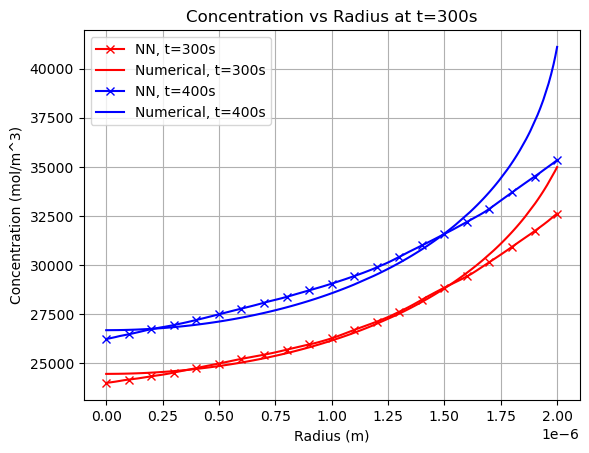

In [106]:
# beyond
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs_adam = 3000
lr_adam = 1e-4
epochs_lbfgs = 0

pinn = beyond(10, 64, 5, 16, nn.SELU, nn.SELU, 100, 100, device).to(device)

_, _, _, _ = pinn.train(epochs_adam, lr_adam, epochs_lbfgs)

r = torch.linspace(0, 1, 101).view(-1, 1).to(device).requires_grad_(True)
t = torch.tensor(0.75).repeat(101).view(-1, 1).requires_grad_(True).to(device)
t2 = torch.tensor(1.).repeat(101).view(-1, 1).requires_grad_(True).to(device)

c = pinn.c_max*pinn.forward_c(r, t).cpu().detach().numpy()
c2 = pinn.c_max*pinn.forward_c(r, t2).cpu().detach().numpy()

numerical = pd.read_csv("MATLAB Solver\data.csv")
numerical1 = numerical.iloc[:, 300].to_numpy()
numerical2 = numerical.iloc[:, 400].to_numpy()

r = pinn.Rs*r.cpu().detach().numpy()
r_numerical = np.linspace(0, 2e-6, 10000)

plt.plot(r, c, label='NN, t=300s', marker = 'x', color = 'red', markevery=5)
plt.plot(r_numerical, numerical1, label='Numerical, t=300s', color = 'red', markevery=100)
plt.plot(r, c2, label='NN, t=400s', marker = 'x', color = 'blue', markevery=5)
plt.plot(r_numerical, numerical2, label='Numerical, t=400s', color = 'blue', markevery=100)
plt.legend()
plt.grid(True)
plt.xlabel('Radius (m)')
plt.ylabel('Concentration (mol/m^3)')
plt.title('Concentration vs Radius at t=300s')
plt.show()